In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandAffined,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import numpy as np
import glob
from utils import AverageMeter
from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [3]:
data_dir = "Task09_Spleen/"

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

data_dicts = [{"img": image_name, "seg": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [4]:
train_transform = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityRanged(
            keys=["img"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["img", "seg"], source_key="img"),
        Orientationd(keys=["img", "seg"], axcodes="RAS"),
        Spacingd(keys=["img", "seg"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["img", "seg"],
            label_key="seg",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="img",
            image_threshold=0,
        ),
    ]
    
)
"""
        RandAffined(
             keys=['img', 'seg'],
             mode=('bilinear', 'nearest'),
             prob=1.0, spatial_size=(96, 96, 96),
             rotate_range=(0, 0, np.pi/15),
             scale_range=(0.1, 0.1, 0.1)),"""
val_transform = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityRanged(
            keys=["img"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["img", "seg"], source_key="img"),
        Orientationd(keys=["img", "seg"], axcodes="RAS"),
        Spacingd(keys=["img", "seg"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [5]:
img = train_transform(train_files[0])

#print(post_pred(img[0]["img"]).shape)
print(len(img[0]))
#print(img["img"].shape, img["seg"].shape)

4


In [6]:
train_dataset = CacheDataset(data=train_files, transform=train_transform, cache_rate=1.0, num_workers=os.cpu_count() // 2)
val_dataset = CacheDataset(data=val_files, transform=val_transform, cache_rate=1.0, num_workers=os.cpu_count() // 2)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers= os.cpu_count() // 2)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=os.cpu_count() // 2)

Loading dataset: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]


In [7]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_accuracy = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)

In [8]:
num_epochs = 1000
val_iteration = 2
losses = []
test_losses = []
dice_accs = []
test_dice_accs = []
best_metric = -1
best_metric_epoch = -1

post_pred = AsDiscrete(argmax=True, to_onehot=2)
post_label = AsDiscrete(to_onehot=2)

for epoch in range(num_epochs):
    
    epoch_loss = 0
    epoch_test_loss = 0
    step = 0
    train_run = AverageMeter()
    
    model.train()
    epoch_dice_accs = []

    for idx, batch_data in enumerate(tqdm(train_loader)):

        img, seg = batch_data["img"].to(device), batch_data["seg"].to(device)
        dice_accuracy.reset()
        optimizer.zero_grad()
        output = model(img)
        loss = loss_function(output, seg)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        try:
            for i in range(len(output)):
                dice_accuracy(y_pred=post_pred(output[i]), y=post_label(seg[i]))
            acc, not_nans = dice_accuracy.aggregate()
            train_run.update(acc.item(), not_nans.item())
            dice_accs.append(acc.item())
            
        except Exception as e:
            print(e)
            

    test_epoch_dice_accs = []

    if (epoch + 1) % val_iteration == 0:
        model.eval()
        val_run = AverageMeter()
        with torch.no_grad():

            for idx, batch_data in enumerate(val_loader):
                dice_accuracy.reset()
                img, seg = batch_data["img"].to(device), batch_data["seg"].to(device)
                outputs = sliding_window_inference(img, (160, 160, 160), 4, model)
                outputs = [post_pred(i) for i in decollate_batch(outputs)]
                seg = [post_label(i) for i in decollate_batch(seg)]
                dice_accuracy(y_pred=outputs, y=seg)
                acc, not_nans = dice_accuracy.aggregate()
                val_run.update(acc.item(), not_nans.item())
                test_dice_accs.append(acc.item())
                test_epoch_dice_accs.append(acc.item())

                #loss = loss_function(outputs, seg)
                #test_losses.append(loss.item())
                #epoch_test_loss += loss.item()
            

            if np.average(test_epoch_dice_accs) > best_metric:
                best_metric = np.average(test_epoch_dice_accs)
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_spleen_metric_model.pth")
                print("saved new best spleen metric model")
            
            print(f"""
                    Epoch: {epoch + 1} / {num_epochs} 
                    | Train Loss: {epoch_loss / len(train_loader)} 
                    | Train Dice Accuracy: {train_run.avg} 
                    | Test Dice Accuracy: {val_run.avg}
                """)
    else:
        print(f"""
                Epoch: {epoch + 1} / {num_epochs} 
                | Train Loss: {epoch_loss / len(train_loader)} 
                | Train Dice Accuracy: {train_run.avg} 
            """)
    
            


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 1 / 1000 
                | Train Loss: 0.610480971634388 
                | Train Dice Accuracy: 0.5295480372453177 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 2 / 1000 
                    | Train Loss: 0.5849751383066177 
                    | Train Dice Accuracy: 0.6046616582695498 
                    | Test Dice Accuracy: 0.06805492668516105
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 3 / 1000 
                | Train Loss: 0.5725818201899529 
                | Train Dice Accuracy: 0.6398018380822657 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 4 / 1000 
                    | Train Loss: 0.5622642897069454 
                    | Train Dice Accuracy: 0.6816647587535537 
                    | Test Dice Accuracy: 0.08555787305037181
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 5 / 1000 
                | Train Loss: 0.5503670834004879 
                | Train Dice Accuracy: 0.6889436723930495 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 6 / 1000 
                    | Train Loss: 0.550426047295332 
                    | Train Dice Accuracy: 0.7131143681845575 
                    | Test Dice Accuracy: 0.08013370550341076
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 7 / 1000 
                | Train Loss: 0.5323689859360456 
                | Train Dice Accuracy: 0.7274930534559653 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 8 / 1000 
                    | Train Loss: 0.5288587212562561 
                    | Train Dice Accuracy: 0.7210914963029426 
                    | Test Dice Accuracy: 0.07830533385276794
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 9 / 1000 
                | Train Loss: 0.5204591285437346 
                | Train Dice Accuracy: 0.7410713663888634 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 10 / 1000 
                    | Train Loss: 0.5132973771542311 
                    | Train Dice Accuracy: 0.7387696611988652 
                    | Test Dice Accuracy: 0.11732560934291945
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 11 / 1000 
                | Train Loss: 0.5163923278450966 
                | Train Dice Accuracy: 0.7476269605573914 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 12 / 1000 
                    | Train Loss: 0.49384528398513794 
                    | Train Dice Accuracy: 0.7575485073359667 
                    | Test Dice Accuracy: 0.05357986709309949
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 13 / 1000 
                | Train Loss: 0.4914166294038296 
                | Train Dice Accuracy: 0.7841125136223909 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 14 / 1000 
                    | Train Loss: 0.4807205144315958 
                    | Train Dice Accuracy: 0.7893986078451306 
                    | Test Dice Accuracy: 0.056813896323243775
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 15 / 1000 
                | Train Loss: 0.48155794478952885 
                | Train Dice Accuracy: 0.790877985122592 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 16 / 1000 
                    | Train Loss: 0.4547612424939871 
                    | Train Dice Accuracy: 0.8043184380186089 
                    | Test Dice Accuracy: 0.04472721512946817
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 17 / 1000 
                | Train Loss: 0.4566173180937767 
                | Train Dice Accuracy: 0.8188520132381225 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 18 / 1000 
                    | Train Loss: 0.44864796102046967 
                    | Train Dice Accuracy: 0.8159938810600175 
                    | Test Dice Accuracy: 0.0997246764600277
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 19 / 1000 
                | Train Loss: 0.4472000990062952 
                | Train Dice Accuracy: 0.8397933010849656 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 20 / 1000 
                    | Train Loss: 0.4341583177447319 
                    | Train Dice Accuracy: 0.8390381664311121 
                    | Test Dice Accuracy: 0.12092266935441229
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 21 / 1000 
                | Train Loss: 0.41605900041759014 
                | Train Dice Accuracy: 0.84109192710739 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 22 / 1000 
                    | Train Loss: 0.4197402074933052 
                    | Train Dice Accuracy: 0.8584370177309468 
                    | Test Dice Accuracy: 0.0688684011499087
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 23 / 1000 
                | Train Loss: 0.42015836387872696 
                | Train Dice Accuracy: 0.8415607020810798 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 24 / 1000 
                    | Train Loss: 0.4154667891561985 
                    | Train Dice Accuracy: 0.8403018399583342 
                    | Test Dice Accuracy: 0.1152468439605501
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 25 / 1000 
                | Train Loss: 0.4052140135318041 
                | Train Dice Accuracy: 0.8435618110678412 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 26 / 1000 
                    | Train Loss: 0.37555752508342266 
                    | Train Dice Accuracy: 0.8616155459817532 
                    | Test Dice Accuracy: 0.053210788095990814
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 27 / 1000 
                | Train Loss: 0.4110723193734884 
                | Train Dice Accuracy: 0.8409047129516778 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 28 / 1000 
                    | Train Loss: 0.3850337900221348 
                    | Train Dice Accuracy: 0.8504422817529584 
                    | Test Dice Accuracy: 0.05980461722032891
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 29 / 1000 
                | Train Loss: 0.3872073907405138 
                | Train Dice Accuracy: 0.8532104315278737 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 30 / 1000 
                    | Train Loss: 0.38580600917339325 
                    | Train Dice Accuracy: 0.8653320104863162 
                    | Test Dice Accuracy: 0.06184695360975133
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 31 / 1000 
                | Train Loss: 0.3728746175765991 
                | Train Dice Accuracy: 0.8586053859203233 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 32 / 1000 
                    | Train Loss: 0.3743111118674278 
                    | Train Dice Accuracy: 0.8805090126238371 
                    | Test Dice Accuracy: 0.08217115369107988
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 33 / 1000 
                | Train Loss: 0.3469220455735922 
                | Train Dice Accuracy: 0.8670661553208318 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 34 / 1000 
                    | Train Loss: 0.3620939925312996 
                    | Train Dice Accuracy: 0.8741505314354543 
                    | Test Dice Accuracy: 0.06512646025253667
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 35 / 1000 
                | Train Loss: 0.34618173725903034 
                | Train Dice Accuracy: 0.875492794524639 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 36 / 1000 
                    | Train Loss: 0.34745309315621853 
                    | Train Dice Accuracy: 0.8698607495386307 
                    | Test Dice Accuracy: 0.05954110684494177
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 37 / 1000 
                | Train Loss: 0.33885545283555984 
                | Train Dice Accuracy: 0.8773250957419969 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 38 / 1000 
                    | Train Loss: 0.3359177578240633 
                    | Train Dice Accuracy: 0.8969709479531577 
                    | Test Dice Accuracy: 0.07886295724246237
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 39 / 1000 
                | Train Loss: 0.3319596881046891 
                | Train Dice Accuracy: 0.8774825483560562 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 40 / 1000 
                    | Train Loss: 0.33467657305300236 
                    | Train Dice Accuracy: 0.8823789480614336 
                    | Test Dice Accuracy: 0.0625319644394848
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 41 / 1000 
                | Train Loss: 0.34528348222374916 
                | Train Dice Accuracy: 0.881156472102651 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 42 / 1000 
                    | Train Loss: 0.3238226920366287 
                    | Train Dice Accuracy: 0.8823623518421225 
                    | Test Dice Accuracy: 0.0719085776557525
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 43 / 1000 
                | Train Loss: 0.32132852729409933 
                | Train Dice Accuracy: 0.9042168711599016 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 44 / 1000 
                    | Train Loss: 0.31282310374081135 
                    | Train Dice Accuracy: 0.9030696517891355 
                    | Test Dice Accuracy: 0.06132716809709867
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 45 / 1000 
                | Train Loss: 0.34469184651970863 
                | Train Dice Accuracy: 0.883474307117008 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 46 / 1000 
                    | Train Loss: 0.3113128989934921 
                    | Train Dice Accuracy: 0.8625031720267402 
                    | Test Dice Accuracy: 0.07213160871631569
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 47 / 1000 
                | Train Loss: 0.30524913780391216 
                | Train Dice Accuracy: 0.8971948343487929 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 48 / 1000 
                    | Train Loss: 0.31447959039360285 
                    | Train Dice Accuracy: 0.8935234435250826 
                    | Test Dice Accuracy: 0.21872547558612293
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 49 / 1000 
                | Train Loss: 0.2891761874780059 
                | Train Dice Accuracy: 0.8902685554822286 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 50 / 1000 
                    | Train Loss: 0.2831619558855891 
                    | Train Dice Accuracy: 0.9099495531197621 
                    | Test Dice Accuracy: 0.06992269431551297
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 51 / 1000 
                | Train Loss: 0.32215289026498795 
                | Train Dice Accuracy: 0.9079277250824905 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 52 / 1000 
                    | Train Loss: 0.29942325968295336 
                    | Train Dice Accuracy: 0.898819381740236 
                    | Test Dice Accuracy: 0.05338434802575244
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 53 / 1000 
                | Train Loss: 0.2899273131042719 
                | Train Dice Accuracy: 0.9025730534836098 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 54 / 1000 
                    | Train Loss: 0.2896126816049218 
                    | Train Dice Accuracy: 0.8798540378255504 
                    | Test Dice Accuracy: 0.06617280344168346
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 55 / 1000 
                | Train Loss: 0.30607353895902634 
                | Train Dice Accuracy: 0.9044419014957589 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 56 / 1000 
                    | Train Loss: 0.28926952835172415 
                    | Train Dice Accuracy: 0.9088491860915113 
                    | Test Dice Accuracy: 0.05793391406122181
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 57 / 1000 
                | Train Loss: 0.2721704002469778 
                | Train Dice Accuracy: 0.9020241726769341 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 58 / 1000 
                    | Train Loss: 0.2747459886595607 
                    | Train Dice Accuracy: 0.9145823510156738 
                    | Test Dice Accuracy: 0.05484781755755345
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 59 / 1000 
                | Train Loss: 0.2875687265768647 
                | Train Dice Accuracy: 0.9157825753373919 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 60 / 1000 
                    | Train Loss: 0.2836744710803032 
                    | Train Dice Accuracy: 0.9032076246117893 
                    | Test Dice Accuracy: 0.06887494958937168
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 61 / 1000 
                | Train Loss: 0.2844389611855149 
                | Train Dice Accuracy: 0.9162805066422117 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 62 / 1000 
                    | Train Loss: 0.2771905465051532 
                    | Train Dice Accuracy: 0.909115198323893 
                    | Test Dice Accuracy: 0.06534117874171999
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 63 / 1000 
                | Train Loss: 0.2783885970711708 
                | Train Dice Accuracy: 0.910896177882346 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 64 / 1000 
                    | Train Loss: 0.2602444952353835 
                    | Train Dice Accuracy: 0.9101589668441463 
                    | Test Dice Accuracy: 0.07157736437188254
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 65 / 1000 
                | Train Loss: 0.2833138518035412 
                | Train Dice Accuracy: 0.9280600423974116 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 66 / 1000 
                    | Train Loss: 0.26483725756406784 
                    | Train Dice Accuracy: 0.9207097241811664 
                    | Test Dice Accuracy: 0.09066088497638702
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 67 / 1000 
                | Train Loss: 0.2702259849756956 
                | Train Dice Accuracy: 0.9215000483477227 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 68 / 1000 
                    | Train Loss: 0.2706671953201294 
                    | Train Dice Accuracy: 0.9066260730454682 
                    | Test Dice Accuracy: 0.07042349668012725
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 69 / 1000 
                | Train Loss: 0.24188572634011507 
                | Train Dice Accuracy: 0.9187064128451877 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 70 / 1000 
                    | Train Loss: 0.28830852918326855 
                    | Train Dice Accuracy: 0.9129347020671481 
                    | Test Dice Accuracy: 0.08499731868505478
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 71 / 1000 
                | Train Loss: 0.2516889786347747 
                | Train Dice Accuracy: 0.9149472948608048 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 72 / 1000 
                    | Train Loss: 0.2697126418352127 
                    | Train Dice Accuracy: 0.9246958274886293 
                    | Test Dice Accuracy: 0.0630422890600231
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 73 / 1000 
                | Train Loss: 0.2521069822832942 
                | Train Dice Accuracy: 0.9226866166712502 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 74 / 1000 
                    | Train Loss: 0.2501053484156728 
                    | Train Dice Accuracy: 0.91459301852305 
                    | Test Dice Accuracy: 0.07084678030676311
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 75 / 1000 
                | Train Loss: 0.2511612419039011 
                | Train Dice Accuracy: 0.9201351161356326 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 76 / 1000 
                    | Train Loss: 0.2643912360072136 
                    | Train Dice Accuracy: 0.9257841399818096 
                    | Test Dice Accuracy: 0.07513957988056871
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 77 / 1000 
                | Train Loss: 0.26232821494340897 
                | Train Dice Accuracy: 0.9167460264161575 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 78 / 1000 
                    | Train Loss: 0.2597049428150058 
                    | Train Dice Accuracy: 0.9334833466611202 
                    | Test Dice Accuracy: 0.08848041544357936
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 79 / 1000 
                | Train Loss: 0.24770363699644804 
                | Train Dice Accuracy: 0.9156918107369624 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 80 / 1000 
                    | Train Loss: 0.24690588656812906 
                    | Train Dice Accuracy: 0.9278952701849872 
                    | Test Dice Accuracy: 0.0589378864193956
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 81 / 1000 
                | Train Loss: 0.29077798686921597 
                | Train Dice Accuracy: 0.9064775261168296 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 82 / 1000 
                    | Train Loss: 0.2749075898900628 
                    | Train Dice Accuracy: 0.9265106099729354 
                    | Test Dice Accuracy: 0.0776464639024602
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 83 / 1000 
                | Train Loss: 0.2585392827168107 
                | Train Dice Accuracy: 0.9051417903416717 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 84 / 1000 
                    | Train Loss: 0.2658049860037863 
                    | Train Dice Accuracy: 0.9146131423284423 
                    | Test Dice Accuracy: 0.12993237003684044
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 85 / 1000 
                | Train Loss: 0.23591846227645874 
                | Train Dice Accuracy: 0.9250044852631277 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 86 / 1000 
                    | Train Loss: 0.242819057777524 
                    | Train Dice Accuracy: 0.9323240635006926 
                    | Test Dice Accuracy: 0.07056425967150265
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 87 / 1000 
                | Train Loss: 0.25772444903850555 
                | Train Dice Accuracy: 0.9332406072389512 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 88 / 1000 
                    | Train Loss: 0.2456688741222024 
                    | Train Dice Accuracy: 0.9246488989785661 
                    | Test Dice Accuracy: 0.08195514749321672
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 89 / 1000 
                | Train Loss: 0.24013112392276525 
                | Train Dice Accuracy: 0.9343746067764603 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 90 / 1000 
                    | Train Loss: 0.2309542503207922 
                    | Train Dice Accuracy: 0.8970515733248337 
                    | Test Dice Accuracy: 0.07244843223856555
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 91 / 1000 
                | Train Loss: 0.2458480317145586 
                | Train Dice Accuracy: 0.9216205621207202 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 92 / 1000 
                    | Train Loss: 0.23210174590349197 
                    | Train Dice Accuracy: 0.9226258002459731 
                    | Test Dice Accuracy: 0.09515071287751198
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 93 / 1000 
                | Train Loss: 0.23860917054116726 
                | Train Dice Accuracy: 0.9272559279695564 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 94 / 1000 
                    | Train Loss: 0.2557867029681802 
                    | Train Dice Accuracy: 0.9143100302543998 
                    | Test Dice Accuracy: 0.26910851067966884
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 95 / 1000 
                | Train Loss: 0.2593510178849101 
                | Train Dice Accuracy: 0.895728325843811 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 96 / 1000 
                    | Train Loss: 0.2323256004601717 
                    | Train Dice Accuracy: 0.9144731356339021 
                    | Test Dice Accuracy: 0.0602981091166536
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 97 / 1000 
                | Train Loss: 0.2421812992542982 
                | Train Dice Accuracy: 0.9354116320610046 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 98 / 1000 
                    | Train Loss: 0.19553101202473044 
                    | Train Dice Accuracy: 0.9229882273984992 
                    | Test Dice Accuracy: 0.06197690301471286
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 99 / 1000 
                | Train Loss: 0.23124095425009727 
                | Train Dice Accuracy: 0.9257835147018256 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 100 / 1000 
                    | Train Loss: 0.20113376062363386 
                    | Train Dice Accuracy: 0.9258369152483187 
                    | Test Dice Accuracy: 0.08612288265592521
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 101 / 1000 
                | Train Loss: 0.24842726904898882 
                | Train Dice Accuracy: 0.9294228981918012 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 102 / 1000 
                    | Train Loss: 0.2428598701953888 
                    | Train Dice Accuracy: 0.9155105751588803 
                    | Test Dice Accuracy: 0.06966237723827362
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 103 / 1000 
                | Train Loss: 0.19293704675510526 
                | Train Dice Accuracy: 0.9338038434497024 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 104 / 1000 
                    | Train Loss: 0.24878318421542645 
                    | Train Dice Accuracy: 0.9481947381715268 
                    | Test Dice Accuracy: 0.19934199957384002
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 105 / 1000 
                | Train Loss: 0.24504608567804098 
                | Train Dice Accuracy: 0.933234600525982 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 106 / 1000 
                    | Train Loss: 0.21678748447448015 
                    | Train Dice Accuracy: 0.9270681031725624 
                    | Test Dice Accuracy: 0.06735265254974365
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 107 / 1000 
                | Train Loss: 0.21391133777797222 
                | Train Dice Accuracy: 0.9345316892345202 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 108 / 1000 
                    | Train Loss: 0.20452357828617096 
                    | Train Dice Accuracy: 0.9275632294019064 
                    | Test Dice Accuracy: 0.06186271748609013
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 109 / 1000 
                | Train Loss: 0.25969761796295643 
                | Train Dice Accuracy: 0.9187555543013981 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 110 / 1000 
                    | Train Loss: 0.2415290679782629 
                    | Train Dice Accuracy: 0.9431203027661337 
                    | Test Dice Accuracy: 0.11571218487289217
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 111 / 1000 
                | Train Loss: 0.2220759131014347 
                | Train Dice Accuracy: 0.9263315214414031 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 112 / 1000 
                    | Train Loss: 0.21418746188282967 
                    | Train Dice Accuracy: 0.9360669613431353 
                    | Test Dice Accuracy: 0.07330857858889633
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 113 / 1000 
                | Train Loss: 0.1891266405582428 
                | Train Dice Accuracy: 0.9243909320105677 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 114 / 1000 
                    | Train Loss: 0.23707033228129148 
                    | Train Dice Accuracy: 0.9372108598455998 
                    | Test Dice Accuracy: 0.08260408768223391
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 115 / 1000 
                | Train Loss: 0.20923233730718493 
                | Train Dice Accuracy: 0.9254494365555288 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 116 / 1000 
                    | Train Loss: 0.23194777173921466 
                    | Train Dice Accuracy: 0.9173532169535413 
                    | Test Dice Accuracy: 0.08636393294566208
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 117 / 1000 
                | Train Loss: 0.21390202268958092 
                | Train Dice Accuracy: 0.9349319157512507 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 118 / 1000 
                    | Train Loss: 0.23233173042535782 
                    | Train Dice Accuracy: 0.9495494916325524 
                    | Test Dice Accuracy: 0.0869905466420783
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 119 / 1000 
                | Train Loss: 0.1909644273109734 
                | Train Dice Accuracy: 0.9472853854098128 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 120 / 1000 
                    | Train Loss: 0.21607417985796928 
                    | Train Dice Accuracy: 0.9214189442818475 
                    | Test Dice Accuracy: 0.08403534524970585
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 121 / 1000 
                | Train Loss: 0.20235629566013813 
                | Train Dice Accuracy: 0.9477986231926949 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 122 / 1000 
                    | Train Loss: 0.2008115230128169 
                    | Train Dice Accuracy: 0.9290058056869849 
                    | Test Dice Accuracy: 0.07937658971382512
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 123 / 1000 
                | Train Loss: 0.21792751969769597 
                | Train Dice Accuracy: 0.9443551721396269 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 124 / 1000 
                    | Train Loss: 0.24616940040141344 
                    | Train Dice Accuracy: 0.9474671462687051 
                    | Test Dice Accuracy: 0.09635594901111391
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 125 / 1000 
                | Train Loss: 0.2070145159959793 
                | Train Dice Accuracy: 0.9502723076277309 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 126 / 1000 
                    | Train Loss: 0.1988053717650473 
                    | Train Dice Accuracy: 0.9473594876184855 
                    | Test Dice Accuracy: 0.07515357558925946
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 127 / 1000 
                | Train Loss: 0.22110501118004322 
                | Train Dice Accuracy: 0.9358410829747165 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 128 / 1000 
                    | Train Loss: 0.20839719381183386 
                    | Train Dice Accuracy: 0.9477706532235499 
                    | Test Dice Accuracy: 0.08857284300029278
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 129 / 1000 
                | Train Loss: 0.21583192236721516 
                | Train Dice Accuracy: 0.9492185479598426 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 130 / 1000 
                    | Train Loss: 0.19309129938483238 
                    | Train Dice Accuracy: 0.9259773442480299 
                    | Test Dice Accuracy: 0.09742573731475407
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 131 / 1000 
                | Train Loss: 0.22141621448099613 
                | Train Dice Accuracy: 0.9365393123894095 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 132 / 1000 
                    | Train Loss: 0.1901829605922103 
                    | Train Dice Accuracy: 0.9426536373116753 
                    | Test Dice Accuracy: 0.09494823921057913
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 133 / 1000 
                | Train Loss: 0.21883213985711336 
                | Train Dice Accuracy: 0.9448715453976196 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 134 / 1000 
                    | Train Loss: 0.22532759420573711 
                    | Train Dice Accuracy: 0.9435594307867836 
                    | Test Dice Accuracy: 0.12017224522100554
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 135 / 1000 
                | Train Loss: 0.17649568524211645 
                | Train Dice Accuracy: 0.9338298291618647 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 136 / 1000 
                    | Train Loss: 0.16805497091263533 
                    | Train Dice Accuracy: 0.9412139902512232 
                    | Test Dice Accuracy: 0.07659211216701402
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 137 / 1000 
                | Train Loss: 0.19780375994741917 
                | Train Dice Accuracy: 0.9375247394179439 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 138 / 1000 
                    | Train Loss: 0.24267634842544794 
                    | Train Dice Accuracy: 0.9286386932645525 
                    | Test Dice Accuracy: 0.10273428944249947
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 139 / 1000 
                | Train Loss: 0.18136403802782297 
                | Train Dice Accuracy: 0.9544605345469419 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 140 / 1000 
                    | Train Loss: 0.2168560167774558 
                    | Train Dice Accuracy: 0.953207955541204 
                    | Test Dice Accuracy: 0.15118088490433162
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 141 / 1000 
                | Train Loss: 0.1974034570157528 
                | Train Dice Accuracy: 0.9492059929655232 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 142 / 1000 
                    | Train Loss: 0.19290472008287907 
                    | Train Dice Accuracy: 0.9441171137455902 
                    | Test Dice Accuracy: 0.14189771066109338
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 143 / 1000 
                | Train Loss: 0.18531907675787807 
                | Train Dice Accuracy: 0.9492274129013131 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 144 / 1000 
                    | Train Loss: 0.24059615284204483 
                    | Train Dice Accuracy: 0.9409044141379687 
                    | Test Dice Accuracy: 0.1441716021961636
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 145 / 1000 
                | Train Loss: 0.20887748431414366 
                | Train Dice Accuracy: 0.9542665274490213 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 146 / 1000 
                    | Train Loss: 0.21641021687537432 
                    | Train Dice Accuracy: 0.9450462144305448 
                    | Test Dice Accuracy: 0.14679360513885817
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 147 / 1000 
                | Train Loss: 0.19295686716213822 
                | Train Dice Accuracy: 0.9493388448833325 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 148 / 1000 
                    | Train Loss: 0.1922912986483425 
                    | Train Dice Accuracy: 0.9440864316404682 
                    | Test Dice Accuracy: 0.16202479518122143
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 149 / 1000 
                | Train Loss: 0.1896230042912066 
                | Train Dice Accuracy: 0.965806797216105 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 150 / 1000 
                    | Train Loss: 0.2083223150111735 
                    | Train Dice Accuracy: 0.9571895635915253 
                    | Test Dice Accuracy: 0.13001424777838919
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 151 / 1000 
                | Train Loss: 0.19192650308832526 
                | Train Dice Accuracy: 0.9505750186946413 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 152 / 1000 
                    | Train Loss: 0.21116831246763468 
                    | Train Dice Accuracy: 0.9510641265138288 
                    | Test Dice Accuracy: 0.10583086394601399
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 153 / 1000 
                | Train Loss: 0.1851804405450821 
                | Train Dice Accuracy: 0.9459602703336137 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 154 / 1000 
                    | Train Loss: 0.20928531233221292 
                    | Train Dice Accuracy: 0.9534881962856776 
                    | Test Dice Accuracy: 0.21243917362557518
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 155 / 1000 
                | Train Loss: 0.21065604873001575 
                | Train Dice Accuracy: 0.9449840399706475 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 156 / 1000 
                    | Train Loss: 0.18207215750589967 
                    | Train Dice Accuracy: 0.9548397905206027 
                    | Test Dice Accuracy: 0.10794370869795482
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 157 / 1000 
                | Train Loss: 0.1975020095705986 
                | Train Dice Accuracy: 0.9473955029690707 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 158 / 1000 
                    | Train Loss: 0.1992395743727684 
                    | Train Dice Accuracy: 0.9550394560689124 
                    | Test Dice Accuracy: 0.18074948423438603
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 159 / 1000 
                | Train Loss: 0.22814198676496744 
                | Train Dice Accuracy: 0.9656618529675054 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 160 / 1000 
                    | Train Loss: 0.21063724299892783 
                    | Train Dice Accuracy: 0.9665921738273219 
                    | Test Dice Accuracy: 0.37839121288723415
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 161 / 1000 
                | Train Loss: 0.2026324449107051 
                | Train Dice Accuracy: 0.949344285108425 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 162 / 1000 
                    | Train Loss: 0.18105503264814615 
                    | Train Dice Accuracy: 0.9516521559520201 
                    | Test Dice Accuracy: 0.2809044329656495
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 163 / 1000 
                | Train Loss: 0.19981186417862773 
                | Train Dice Accuracy: 0.950579972322597 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 164 / 1000 
                    | Train Loss: 0.22651915345340967 
                    | Train Dice Accuracy: 0.9525621309876442 
                    | Test Dice Accuracy: 0.6588639749421014
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 165 / 1000 
                | Train Loss: 0.17385370191186666 
                | Train Dice Accuracy: 0.949563063848179 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 166 / 1000 
                    | Train Loss: 0.2060901049990207 
                    | Train Dice Accuracy: 0.9574799905970411 
                    | Test Dice Accuracy: 0.32797713081041974
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 167 / 1000 
                | Train Loss: 0.21657042391598225 
                | Train Dice Accuracy: 0.9528524861449287 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 168 / 1000 
                    | Train Loss: 0.21822483045980334 
                    | Train Dice Accuracy: 0.958246055417336 
                    | Test Dice Accuracy: 0.5366174744235145
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 169 / 1000 
                | Train Loss: 0.1862287581898272 
                | Train Dice Accuracy: 0.9565355209035611 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 170 / 1000 
                    | Train Loss: 0.18492073100060225 
                    | Train Dice Accuracy: 0.9512633005960272 
                    | Test Dice Accuracy: 0.7221457891994052
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 171 / 1000 
                | Train Loss: 0.15971222170628607 
                | Train Dice Accuracy: 0.9583909250795841 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 172 / 1000 
                    | Train Loss: 0.21593792364001274 
                    | Train Dice Accuracy: 0.9549237222898574 
                    | Test Dice Accuracy: 0.422269355919626
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 173 / 1000 
                | Train Loss: 0.2386064724996686 
                | Train Dice Accuracy: 0.9554093892083448 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 174 / 1000 
                    | Train Loss: 0.15910917124710977 
                    | Train Dice Accuracy: 0.961014786735177 
                    | Test Dice Accuracy: 0.22488997876644135
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 175 / 1000 
                | Train Loss: 0.1733779744245112 
                | Train Dice Accuracy: 0.9532097932454702 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 176 / 1000 
                    | Train Loss: 0.19047398585826159 
                    | Train Dice Accuracy: 0.9557223519600859 
                    | Test Dice Accuracy: 0.462602657576402
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 177 / 1000 
                | Train Loss: 0.19219757430255413 
                | Train Dice Accuracy: 0.9487257283953477 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 178 / 1000 
                    | Train Loss: 0.20381331350654364 
                    | Train Dice Accuracy: 0.9594705681100276 
                    | Test Dice Accuracy: 0.16578121152189043
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 179 / 1000 
                | Train Loss: 0.19090178608894348 
                | Train Dice Accuracy: 0.9595483708604474 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 180 / 1000 
                    | Train Loss: 0.1697459821589291 
                    | Train Dice Accuracy: 0.9611010800708424 
                    | Test Dice Accuracy: 0.6382433738973405
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 181 / 1000 
                | Train Loss: 0.20073013147339225 
                | Train Dice Accuracy: 0.9532856722210729 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 182 / 1000 
                    | Train Loss: 0.16159507492557168 
                    | Train Dice Accuracy: 0.9505804173151652 
                    | Test Dice Accuracy: 0.2676704054077466
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 183 / 1000 
                | Train Loss: 0.2215941739268601 
                | Train Dice Accuracy: 0.9675333139373035 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 184 / 1000 
                    | Train Loss: 0.1910802039783448 
                    | Train Dice Accuracy: 0.9482593101645829 
                    | Test Dice Accuracy: 0.4734811683495839
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 185 / 1000 
                | Train Loss: 0.20630228985100985 
                | Train Dice Accuracy: 0.9439606741767064 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 186 / 1000 
                    | Train Loss: 0.22264049295336008 
                    | Train Dice Accuracy: 0.9614297990660066 
                    | Test Dice Accuracy: 0.7243163188298544
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 187 / 1000 
                | Train Loss: 0.209771697409451 
                | Train Dice Accuracy: 0.9472897819510089 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 188 / 1000 
                    | Train Loss: 0.18004630226641893 
                    | Train Dice Accuracy: 0.9629151125748953 
                    | Test Dice Accuracy: 0.9007378882831998
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 189 / 1000 
                | Train Loss: 0.16801340016536415 
                | Train Dice Accuracy: 0.9509453546305943 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 190 / 1000 
                    | Train Loss: 0.20270896144211292 
                    | Train Dice Accuracy: 0.961696610066563 
                    | Test Dice Accuracy: 0.6565245257483588
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 191 / 1000 
                | Train Loss: 0.17977265128865838 
                | Train Dice Accuracy: 0.9606027325726874 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 192 / 1000 
                    | Train Loss: 0.20269652176648378 
                    | Train Dice Accuracy: 0.9628126095821508 
                    | Test Dice Accuracy: 0.6372552182939317
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 193 / 1000 
                | Train Loss: 0.21273437701165676 
                | Train Dice Accuracy: 0.951367974846284 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 194 / 1000 
                    | Train Loss: 0.20748661179095507 
                    | Train Dice Accuracy: 0.95984626469158 
                    | Test Dice Accuracy: 0.8668118516604105
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 195 / 1000 
                | Train Loss: 0.20518193440511823 
                | Train Dice Accuracy: 0.9487277652736001 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 196 / 1000 
                    | Train Loss: 0.19668002054095268 
                    | Train Dice Accuracy: 0.9634630165189645 
                    | Test Dice Accuracy: 0.5628477500544654
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 197 / 1000 
                | Train Loss: 0.18995476816780865 
                | Train Dice Accuracy: 0.9583895491999249 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 198 / 1000 
                    | Train Loss: 0.13521952205337584 
                    | Train Dice Accuracy: 0.9579844604367795 
                    | Test Dice Accuracy: 0.9169389605522156
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 199 / 1000 
                | Train Loss: 0.19025519024580717 
                | Train Dice Accuracy: 0.9615356150631592 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 200 / 1000 
                    | Train Loss: 0.19215992745012045 
                    | Train Dice Accuracy: 0.9538604137509368 
                    | Test Dice Accuracy: 0.8072918554147085
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 201 / 1000 
                | Train Loss: 0.17718250304460526 
                | Train Dice Accuracy: 0.9516173633515026 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 202 / 1000 
                    | Train Loss: 0.18801884818822145 
                    | Train Dice Accuracy: 0.9430013748064433 
                    | Test Dice Accuracy: 0.3110538033975495
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 203 / 1000 
                | Train Loss: 0.2195733366534114 
                | Train Dice Accuracy: 0.9503734002892787 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 204 / 1000 
                    | Train Loss: 0.20404000161215663 
                    | Train Dice Accuracy: 0.9546759359116824 
                    | Test Dice Accuracy: 0.8583468794822693
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 205 / 1000 
                | Train Loss: 0.20954495389014482 
                | Train Dice Accuracy: 0.9517878556703504 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 206 / 1000 
                    | Train Loss: 0.2160761682316661 
                    | Train Dice Accuracy: 0.9579178645060613 
                    | Test Dice Accuracy: 0.9011995262569852
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 207 / 1000 
                | Train Loss: 0.1826699711382389 
                | Train Dice Accuracy: 0.9479676300829107 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 208 / 1000 
                    | Train Loss: 0.2052106410264969 
                    | Train Dice Accuracy: 0.9541272537888221 
                    | Test Dice Accuracy: 0.731896291176478
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 209 / 1000 
                | Train Loss: 0.1840983210131526 
                | Train Dice Accuracy: 0.9463857117049191 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 210 / 1000 
                    | Train Loss: 0.17408509133383632 
                    | Train Dice Accuracy: 0.9553490370512009 
                    | Test Dice Accuracy: 0.9165162709024217
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 211 / 1000 
                | Train Loss: 0.1504776463843882 
                | Train Dice Accuracy: 0.9558504864904616 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 212 / 1000 
                    | Train Loss: 0.17007943661883473 
                    | Train Dice Accuracy: 0.9539212324060835 
                    | Test Dice Accuracy: 0.6131312847137451
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 213 / 1000 
                | Train Loss: 0.20564243756234646 
                | Train Dice Accuracy: 0.9580158930254209 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 214 / 1000 
                    | Train Loss: 0.1726638393010944 
                    | Train Dice Accuracy: 0.9517897993191335 
                    | Test Dice Accuracy: 0.5452052536937926
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 215 / 1000 
                | Train Loss: 0.17801229050382972 
                | Train Dice Accuracy: 0.9578960543378777 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 216 / 1000 
                    | Train Loss: 0.2306307191029191 
                    | Train Dice Accuracy: 0.9484069963682045 
                    | Test Dice Accuracy: 0.9312336908446418
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 217 / 1000 
                | Train Loss: 0.1763570827897638 
                | Train Dice Accuracy: 0.9605866886607004 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 218 / 1000 
                    | Train Loss: 0.1847709584981203 
                    | Train Dice Accuracy: 0.957963773457136 
                    | Test Dice Accuracy: 0.9295645091268752
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 219 / 1000 
                | Train Loss: 0.21542650926858187 
                | Train Dice Accuracy: 0.9578971702318925 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 220 / 1000 
                    | Train Loss: 0.1971010621637106 
                    | Train Dice Accuracy: 0.9545552254842481 
                    | Test Dice Accuracy: 0.8397390776210361
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 221 / 1000 
                | Train Loss: 0.19151100423187017 
                | Train Dice Accuracy: 0.9636986697783493 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 222 / 1000 
                    | Train Loss: 0.18435624334961176 
                    | Train Dice Accuracy: 0.962585985660553 
                    | Test Dice Accuracy: 0.9215503798590766
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 223 / 1000 
                | Train Loss: 0.19806840736418962 
                | Train Dice Accuracy: 0.9551578219805923 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 224 / 1000 
                    | Train Loss: 0.2224805927835405 
                    | Train Dice Accuracy: 0.9563188172768855 
                    | Test Dice Accuracy: 0.9343109726905823
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 225 / 1000 
                | Train Loss: 0.1777106705121696 
                | Train Dice Accuracy: 0.9631768248048246 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 226 / 1000 
                    | Train Loss: 0.17163554159924388 
                    | Train Dice Accuracy: 0.9579871689731424 
                    | Test Dice Accuracy: 0.9291263090239631
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 227 / 1000 
                | Train Loss: 0.19409233005717397 
                | Train Dice Accuracy: 0.9545305019201235 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 228 / 1000 
                    | Train Loss: 0.15391320921480656 
                    | Train Dice Accuracy: 0.9634530643176605 
                    | Test Dice Accuracy: 0.8238333198759291
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 229 / 1000 
                | Train Loss: 0.18608504021540284 
                | Train Dice Accuracy: 0.9536192219378212 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 230 / 1000 
                    | Train Loss: 0.21921515464782715 
                    | Train Dice Accuracy: 0.9496684196449462 
                    | Test Dice Accuracy: 0.7883140709665086
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 231 / 1000 
                | Train Loss: 0.1715488329064101 
                | Train Dice Accuracy: 0.9421441453454741 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 232 / 1000 
                    | Train Loss: 0.16329824994318187 
                    | Train Dice Accuracy: 0.9461752226842302 
                    | Test Dice Accuracy: 0.6712012853887346
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 233 / 1000 
                | Train Loss: 0.19999462738633156 
                | Train Dice Accuracy: 0.952714108139555 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 234 / 1000 
                    | Train Loss: 0.1626868846360594 
                    | Train Dice Accuracy: 0.9527227207684196 
                    | Test Dice Accuracy: 0.9074021710289849
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 235 / 1000 
                | Train Loss: 0.19118448626250029 
                | Train Dice Accuracy: 0.9603861958481544 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 236 / 1000 
                    | Train Loss: 0.16791298473253846 
                    | Train Dice Accuracy: 0.9583656397732822 
                    | Test Dice Accuracy: 0.8075965642929077
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 237 / 1000 
                | Train Loss: 0.21158369560725987 
                | Train Dice Accuracy: 0.9576456455522747 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 238 / 1000 
                    | Train Loss: 0.18736955523490906 
                    | Train Dice Accuracy: 0.9631267669044923 
                    | Test Dice Accuracy: 0.9226068655649821
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 239 / 1000 
                | Train Loss: 0.20745612494647503 
                | Train Dice Accuracy: 0.959877319598312 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 240 / 1000 
                    | Train Loss: 0.18061673268675804 
                    | Train Dice Accuracy: 0.9539228059829922 
                    | Test Dice Accuracy: 0.9040538999769423
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 241 / 1000 
                | Train Loss: 0.1766035456676036 
                | Train Dice Accuracy: 0.9567565354732198 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 242 / 1000 
                    | Train Loss: 0.1925533846952021 
                    | Train Dice Accuracy: 0.9619632738296975 
                    | Test Dice Accuracy: 0.23986556215418708
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 243 / 1000 
                | Train Loss: 0.17726867739111185 
                | Train Dice Accuracy: 0.9450043895027854 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 244 / 1000 
                    | Train Loss: 0.21583443460986018 
                    | Train Dice Accuracy: 0.958378023826159 
                    | Test Dice Accuracy: 0.849126762813992
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 245 / 1000 
                | Train Loss: 0.1978630507364869 
                | Train Dice Accuracy: 0.968862761769976 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 246 / 1000 
                    | Train Loss: 0.19835678301751614 
                    | Train Dice Accuracy: 0.9574596725159408 
                    | Test Dice Accuracy: 0.9239329033427768
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 247 / 1000 
                | Train Loss: 0.17410749779082835 
                | Train Dice Accuracy: 0.9399779759714956 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 248 / 1000 
                    | Train Loss: 0.19156856485642493 
                    | Train Dice Accuracy: 0.9595226570267543 
                    | Test Dice Accuracy: 0.9087573091189066
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 249 / 1000 
                | Train Loss: 0.17963244137354195 
                | Train Dice Accuracy: 0.9601320110707788 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 250 / 1000 
                    | Train Loss: 0.19075294653885067 
                    | Train Dice Accuracy: 0.963449713209985 
                    | Test Dice Accuracy: 0.899395744005839
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 251 / 1000 
                | Train Loss: 0.18522326974198222 
                | Train Dice Accuracy: 0.9588526432160978 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 252 / 1000 
                    | Train Loss: 0.1636459839064628 
                    | Train Dice Accuracy: 0.9515946691880847 
                    | Test Dice Accuracy: 0.8997331394089593
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 253 / 1000 
                | Train Loss: 0.18106380896642804 
                | Train Dice Accuracy: 0.9544274650411122 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 254 / 1000 
                    | Train Loss: 0.18593299202620983 
                    | Train Dice Accuracy: 0.9582662388335826 
                    | Test Dice Accuracy: 0.910898831155565
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 255 / 1000 
                | Train Loss: 0.17659431556239724 
                | Train Dice Accuracy: 0.957101098678079 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 256 / 1000 
                    | Train Loss: 0.18733200430870056 
                    | Train Dice Accuracy: 0.9603549006373383 
                    | Test Dice Accuracy: 0.9317293167114258
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 257 / 1000 
                | Train Loss: 0.17742241476662457 
                | Train Dice Accuracy: 0.9599459980605939 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 258 / 1000 
                    | Train Loss: 0.16620111698284745 
                    | Train Dice Accuracy: 0.9629803923167051 
                    | Test Dice Accuracy: 0.9324121872584025
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 259 / 1000 
                | Train Loss: 0.1928504789248109 
                | Train Dice Accuracy: 0.9612596342821076 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 260 / 1000 
                    | Train Loss: 0.20502434042282403 
                    | Train Dice Accuracy: 0.9682159908650595 
                    | Test Dice Accuracy: 0.9131268660227457
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 261 / 1000 
                | Train Loss: 0.20711715216748416 
                | Train Dice Accuracy: 0.9565871545246669 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 262 / 1000 
                    | Train Loss: 0.20082096080295742 
                    | Train Dice Accuracy: 0.9579922974957109 
                    | Test Dice Accuracy: 0.775993181599511
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 263 / 1000 
                | Train Loss: 0.19542323146015406 
                | Train Dice Accuracy: 0.958623727442513 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 264 / 1000 
                    | Train Loss: 0.21458449214696884 
                    | Train Dice Accuracy: 0.9586193653253409 
                    | Test Dice Accuracy: 0.9004946682188246
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 265 / 1000 
                | Train Loss: 0.1612788583151996 
                | Train Dice Accuracy: 0.9536619370828295 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 266 / 1000 
                    | Train Loss: 0.16320554143749177 
                    | Train Dice Accuracy: 0.9562165471347602 
                    | Test Dice Accuracy: 0.8927399383650886
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 267 / 1000 
                | Train Loss: 0.1398246183525771 
                | Train Dice Accuracy: 0.9570857249853904 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 268 / 1000 
                    | Train Loss: 0.19946131249889731 
                    | Train Dice Accuracy: 0.943400195864744 
                    | Test Dice Accuracy: 0.8667047686047025
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 269 / 1000 
                | Train Loss: 0.17928102985024452 
                | Train Dice Accuracy: 0.9508962210165252 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 270 / 1000 
                    | Train Loss: 0.17431612056680024 
                    | Train Dice Accuracy: 0.9589863241812505 
                    | Test Dice Accuracy: 0.6196748581197526
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 271 / 1000 
                | Train Loss: 0.2082967183087021 
                | Train Dice Accuracy: 0.9409330918195662 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 272 / 1000 
                    | Train Loss: 0.1650001045782119 
                    | Train Dice Accuracy: 0.9583858391817879 
                    | Test Dice Accuracy: 0.888939830991957
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 273 / 1000 
                | Train Loss: 0.2039800575003028 
                | Train Dice Accuracy: 0.9616136979489099 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 274 / 1000 
                    | Train Loss: 0.2082301708869636 
                    | Train Dice Accuracy: 0.9618867284943613 
                    | Test Dice Accuracy: 0.9266810284720527
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 275 / 1000 
                | Train Loss: 0.15123322419822216 
                | Train Dice Accuracy: 0.9567958992139428 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 276 / 1000 
                    | Train Loss: 0.17176767042838037 
                    | Train Dice Accuracy: 0.9573564140219667 
                    | Test Dice Accuracy: 0.8832352293862237
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 277 / 1000 
                | Train Loss: 0.20017200359143317 
                | Train Dice Accuracy: 0.955542395137391 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 278 / 1000 
                    | Train Loss: 0.1867808981332928 
                    | Train Dice Accuracy: 0.9678295095201949 
                    | Test Dice Accuracy: 0.9318738513522677
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 279 / 1000 
                | Train Loss: 0.14719379879534245 
                | Train Dice Accuracy: 0.9595929450458951 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 280 / 1000 
                    | Train Loss: 0.196639786940068 
                    | Train Dice Accuracy: 0.9552808056974635 
                    | Test Dice Accuracy: 0.9369872477319505
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 281 / 1000 
                | Train Loss: 0.17920267302542925 
                | Train Dice Accuracy: 0.9593420262160939 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 282 / 1000 
                    | Train Loss: 0.17714030132628977 
                    | Train Dice Accuracy: 0.9627791882110631 
                    | Test Dice Accuracy: 0.9233480427000258
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 283 / 1000 
                | Train Loss: 0.17859213100746274 
                | Train Dice Accuracy: 0.9587248937325543 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 284 / 1000 
                    | Train Loss: 0.14504346228204668 
                    | Train Dice Accuracy: 0.9643522781795926 
                    | Test Dice Accuracy: 0.9310966465208266
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 285 / 1000 
                | Train Loss: 0.20544954808428884 
                | Train Dice Accuracy: 0.955963617534999 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 286 / 1000 
                    | Train Loss: 0.15877640363760293 
                    | Train Dice Accuracy: 0.9575154652466645 
                    | Test Dice Accuracy: 0.9408358865314059
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 287 / 1000 
                | Train Loss: 0.1553413774818182 
                | Train Dice Accuracy: 0.9634180055545257 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 288 / 1000 
                    | Train Loss: 0.184124072548002 
                    | Train Dice Accuracy: 0.959150573445691 
                    | Test Dice Accuracy: 0.9361795849270291
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 289 / 1000 
                | Train Loss: 0.20445268671028316 
                | Train Dice Accuracy: 0.9554741537966435 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 290 / 1000 
                    | Train Loss: 0.17745566391386092 
                    | Train Dice Accuracy: 0.9520901080665238 
                    | Test Dice Accuracy: 0.939737061659495
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 291 / 1000 
                | Train Loss: 0.20786429569125175 
                | Train Dice Accuracy: 0.9697035194019189 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 292 / 1000 
                    | Train Loss: 0.19280686834827065 
                    | Train Dice Accuracy: 0.9695825901641665 
                    | Test Dice Accuracy: 0.9422338141335381
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 293 / 1000 
                | Train Loss: 0.20327372034080327 
                | Train Dice Accuracy: 0.949194933606985 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 294 / 1000 
                    | Train Loss: 0.1689149192534387 
                    | Train Dice Accuracy: 0.9584478960795836 
                    | Test Dice Accuracy: 0.7451940373414092
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 295 / 1000 
                | Train Loss: 0.1918180286884308 
                | Train Dice Accuracy: 0.9546541377555492 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 296 / 1000 
                    | Train Loss: 0.20473850704729557 
                    | Train Dice Accuracy: 0.9474954391425511 
                    | Test Dice Accuracy: 0.8538740542199876
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 297 / 1000 
                | Train Loss: 0.18970091827213764 
                | Train Dice Accuracy: 0.9548745518506959 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 298 / 1000 
                    | Train Loss: 0.1774112731218338 
                    | Train Dice Accuracy: 0.9561377321520159 
                    | Test Dice Accuracy: 0.8345678581131829
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 299 / 1000 
                | Train Loss: 0.18892669677734375 
                | Train Dice Accuracy: 0.9663923693374848 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 300 / 1000 
                    | Train Loss: 0.15814515901729465 
                    | Train Dice Accuracy: 0.9692462566224012 
                    | Test Dice Accuracy: 0.9177208410369025
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 301 / 1000 
                | Train Loss: 0.21625523455440998 
                | Train Dice Accuracy: 0.9689746324608965 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 302 / 1000 
                    | Train Loss: 0.1819991923402995 
                    | Train Dice Accuracy: 0.9634711772896523 
                    | Test Dice Accuracy: 0.71111441983117
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 303 / 1000 
                | Train Loss: 0.17432587081566453 
                | Train Dice Accuracy: 0.9603101520910176 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 304 / 1000 
                    | Train Loss: 0.18595333024859428 
                    | Train Dice Accuracy: 0.9548796359882799 
                    | Test Dice Accuracy: 0.9424394832717048
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 305 / 1000 
                | Train Loss: 0.16601222357712686 
                | Train Dice Accuracy: 0.9624499670446736 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 306 / 1000 
                    | Train Loss: 0.14723929041065276 
                    | Train Dice Accuracy: 0.9599849163161384 
                    | Test Dice Accuracy: 0.9320119288232591
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 307 / 1000 
                | Train Loss: 0.18664396880194545 
                | Train Dice Accuracy: 0.9632455642535308 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 308 / 1000 
                    | Train Loss: 0.1635408157017082 
                    | Train Dice Accuracy: 0.9579910387820249 
                    | Test Dice Accuracy: 0.8367815514405569
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 309 / 1000 
                | Train Loss: 0.17615129007026553 
                | Train Dice Accuracy: 0.9641677292960661 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 310 / 1000 
                    | Train Loss: 0.23110051918774843 
                    | Train Dice Accuracy: 0.9606761242368539 
                    | Test Dice Accuracy: 0.9109971125920614
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 311 / 1000 
                | Train Loss: 0.18932517454959452 
                | Train Dice Accuracy: 0.957120949141333 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 312 / 1000 
                    | Train Loss: 0.1780389128252864 
                    | Train Dice Accuracy: 0.9592556651286815 
                    | Test Dice Accuracy: 0.8944761355717977
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 313 / 1000 
                | Train Loss: 0.16019608336500823 
                | Train Dice Accuracy: 0.9634822658284218 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 314 / 1000 
                    | Train Loss: 0.14908485184423625 
                    | Train Dice Accuracy: 0.9537664480441439 
                    | Test Dice Accuracy: 0.9415231545766195
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 315 / 1000 
                | Train Loss: 0.18319738656282425 
                | Train Dice Accuracy: 0.9633389747420023 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 316 / 1000 
                    | Train Loss: 0.1834941734559834 
                    | Train Dice Accuracy: 0.9545078001640461 
                    | Test Dice Accuracy: 0.9432216154204475
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 317 / 1000 
                | Train Loss: 0.1538694016635418 
                | Train Dice Accuracy: 0.9713502469645366 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 318 / 1000 
                    | Train Loss: 0.16445366432890296 
                    | Train Dice Accuracy: 0.9534879342929737 
                    | Test Dice Accuracy: 0.9341382582982382
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 319 / 1000 
                | Train Loss: 0.1475569277536124 
                | Train Dice Accuracy: 0.9570306369993422 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 320 / 1000 
                    | Train Loss: 0.21789106633514166 
                    | Train Dice Accuracy: 0.9664988404367029 
                    | Test Dice Accuracy: 0.7224187552928925
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 321 / 1000 
                | Train Loss: 0.14195314282551408 
                | Train Dice Accuracy: 0.9590516799846581 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 322 / 1000 
                    | Train Loss: 0.1633431208319962 
                    | Train Dice Accuracy: 0.9661308309258936 
                    | Test Dice Accuracy: 0.9319691790474786
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 323 / 1000 
                | Train Loss: 0.19922043895348907 
                | Train Dice Accuracy: 0.9641040992169153 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 324 / 1000 
                    | Train Loss: 0.17446286883205175 
                    | Train Dice Accuracy: 0.9601176706475949 
                    | Test Dice Accuracy: 0.9141649537616305
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 325 / 1000 
                | Train Loss: 0.1570433785673231 
                | Train Dice Accuracy: 0.9565048068093612 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 326 / 1000 
                    | Train Loss: 0.18167206412181258 
                    | Train Dice Accuracy: 0.9542563774618685 
                    | Test Dice Accuracy: 0.8836075332429674
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 327 / 1000 
                | Train Loss: 0.212140248157084 
                | Train Dice Accuracy: 0.9579288503871515 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 328 / 1000 
                    | Train Loss: 0.1790458452887833 
                    | Train Dice Accuracy: 0.9620594829320908 
                    | Test Dice Accuracy: 0.9387049078941345
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 329 / 1000 
                | Train Loss: 0.19734938512556255 
                | Train Dice Accuracy: 0.9624563167445468 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 330 / 1000 
                    | Train Loss: 0.1927776043303311 
                    | Train Dice Accuracy: 0.9588889124247949 
                    | Test Dice Accuracy: 0.8311815990342034
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 331 / 1000 
                | Train Loss: 0.20279588550329208 
                | Train Dice Accuracy: 0.9535367319369203 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 332 / 1000 
                    | Train Loss: 0.17152985837310553 
                    | Train Dice Accuracy: 0.9614939260373422 
                    | Test Dice Accuracy: 0.9337876107957628
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 333 / 1000 
                | Train Loss: 0.1815948726143688 
                | Train Dice Accuracy: 0.9576643073448429 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 334 / 1000 
                    | Train Loss: 0.1272893634159118 
                    | Train Dice Accuracy: 0.9547073206344208 
                    | Test Dice Accuracy: 0.6971017364412546
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 335 / 1000 
                | Train Loss: 0.1672653816640377 
                | Train Dice Accuracy: 0.9630803835990767 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 336 / 1000 
                    | Train Loss: 0.18718934804201126 
                    | Train Dice Accuracy: 0.9614063974852874 
                    | Test Dice Accuracy: 0.9440523982048035
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 337 / 1000 
                | Train Loss: 0.18422974948771298 
                | Train Dice Accuracy: 0.9538356988660751 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 338 / 1000 
                    | Train Loss: 0.17679970106109977 
                    | Train Dice Accuracy: 0.9630187854722694 
                    | Test Dice Accuracy: 0.9440122048060099
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 339 / 1000 
                | Train Loss: 0.19553343043662608 
                | Train Dice Accuracy: 0.9609000061480504 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 340 / 1000 
                    | Train Loss: 0.16792988660745323 
                    | Train Dice Accuracy: 0.9663934734983182 
                    | Test Dice Accuracy: 0.9460568825403849
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 341 / 1000 
                | Train Loss: 0.1664624430704862 
                | Train Dice Accuracy: 0.9638631030849126 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 342 / 1000 
                    | Train Loss: 0.18227710970677435 
                    | Train Dice Accuracy: 0.9684940846723931 
                    | Test Dice Accuracy: 0.9282616509331597
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 343 / 1000 
                | Train Loss: 0.15254661464132369 
                | Train Dice Accuracy: 0.9626399676895997 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 344 / 1000 
                    | Train Loss: 0.20310792932286859 
                    | Train Dice Accuracy: 0.9426986268747632 
                    | Test Dice Accuracy: 0.8443042271667056
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 345 / 1000 
                | Train Loss: 0.17220319248735905 
                | Train Dice Accuracy: 0.9528606628829782 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 346 / 1000 
                    | Train Loss: 0.20993694895878434 
                    | Train Dice Accuracy: 0.957798801935636 
                    | Test Dice Accuracy: 0.9334212011761136
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 347 / 1000 
                | Train Loss: 0.17452176148071885 
                | Train Dice Accuracy: 0.9572518176684096 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 348 / 1000 
                    | Train Loss: 0.19559016497805715 
                    | Train Dice Accuracy: 0.9545424334320104 
                    | Test Dice Accuracy: 0.9443584349420335
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 349 / 1000 
                | Train Loss: 0.19268796895630658 
                | Train Dice Accuracy: 0.9662168548916871 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 350 / 1000 
                    | Train Loss: 0.16535324440337718 
                    | Train Dice Accuracy: 0.9545230698261865 
                    | Test Dice Accuracy: 0.9302856789694892
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 351 / 1000 
                | Train Loss: 0.17969459481537342 
                | Train Dice Accuracy: 0.9573051001069732 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 352 / 1000 
                    | Train Loss: 0.20565617084503174 
                    | Train Dice Accuracy: 0.9491823056958756 
                    | Test Dice Accuracy: 0.9235128627883064
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 353 / 1000 
                | Train Loss: 0.13927533710375428 
                | Train Dice Accuracy: 0.9590409090865551 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 354 / 1000 
                    | Train Loss: 0.16632325993850827 
                    | Train Dice Accuracy: 0.9679085962269285 
                    | Test Dice Accuracy: 0.8773258725802103
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 355 / 1000 
                | Train Loss: 0.1699694029521197 
                | Train Dice Accuracy: 0.9642973457454541 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 356 / 1000 
                    | Train Loss: 0.20041245454922318 
                    | Train Dice Accuracy: 0.9711870984597639 
                    | Test Dice Accuracy: 0.9061558246612549
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 357 / 1000 
                | Train Loss: 0.17625620029866695 
                | Train Dice Accuracy: 0.9626406554802223 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 358 / 1000 
                    | Train Loss: 0.16305326716974378 
                    | Train Dice Accuracy: 0.9647359018976038 
                    | Test Dice Accuracy: 0.8423005077573988
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 359 / 1000 
                | Train Loss: 0.15974942175671458 
                | Train Dice Accuracy: 0.9559697679874608 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 360 / 1000 
                    | Train Loss: 0.1918381319846958 
                    | Train Dice Accuracy: 0.9592251953944354 
                    | Test Dice Accuracy: 0.6016737868388494
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 361 / 1000 
                | Train Loss: 0.1766979091335088 
                | Train Dice Accuracy: 0.9632875778608851 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 362 / 1000 
                    | Train Loss: 0.19399262056685984 
                    | Train Dice Accuracy: 0.9667973970349931 
                    | Test Dice Accuracy: 0.8802941838900248
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 363 / 1000 
                | Train Loss: 0.19784545479342341 
                | Train Dice Accuracy: 0.9584834016156647 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 364 / 1000 
                    | Train Loss: 0.17559495405294 
                    | Train Dice Accuracy: 0.9589647377302887 
                    | Test Dice Accuracy: 0.6848452289899191
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 365 / 1000 
                | Train Loss: 0.19307479448616505 
                | Train Dice Accuracy: 0.9516697939052138 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 366 / 1000 
                    | Train Loss: 0.1923232558183372 
                    | Train Dice Accuracy: 0.9516676380255512 
                    | Test Dice Accuracy: 0.8967023094495138
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 367 / 1000 
                | Train Loss: 0.15873273205943406 
                | Train Dice Accuracy: 0.9625654827415674 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 368 / 1000 
                    | Train Loss: 0.16842881962656975 
                    | Train Dice Accuracy: 0.9690625708584392 
                    | Test Dice Accuracy: 0.8818282948599921
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 369 / 1000 
                | Train Loss: 0.1983994257170707 
                | Train Dice Accuracy: 0.961381281439162 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 370 / 1000 
                    | Train Loss: 0.18500408995896578 
                    | Train Dice Accuracy: 0.9499734798702625 
                    | Test Dice Accuracy: 0.9267553819550408
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 371 / 1000 
                | Train Loss: 0.17289438843727112 
                | Train Dice Accuracy: 0.9613236208115855 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 372 / 1000 
                    | Train Loss: 0.17396971280686557 
                    | Train Dice Accuracy: 0.9603773497660225 
                    | Test Dice Accuracy: 0.8327987922562493
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 373 / 1000 
                | Train Loss: 0.206997184548527 
                | Train Dice Accuracy: 0.9487797533566097 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 374 / 1000 
                    | Train Loss: 0.21621545124799013 
                    | Train Dice Accuracy: 0.9625488664340047 
                    | Test Dice Accuracy: 0.9339571661419339
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 375 / 1000 
                | Train Loss: 0.1880030296742916 
                | Train Dice Accuracy: 0.9542817939762716 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 376 / 1000 
                    | Train Loss: 0.21271053212694824 
                    | Train Dice Accuracy: 0.9566817378195432 
                    | Test Dice Accuracy: 0.8456438382466634
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 377 / 1000 
                | Train Loss: 0.14832141040824354 
                | Train Dice Accuracy: 0.9636078889348677 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 378 / 1000 
                    | Train Loss: 0.1984010215383023 
                    | Train Dice Accuracy: 0.9648536418286545 
                    | Test Dice Accuracy: 0.946027053727044
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 379 / 1000 
                | Train Loss: 0.16581645142287016 
                | Train Dice Accuracy: 0.9619820626903343 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 380 / 1000 
                    | Train Loss: 0.1727740252390504 
                    | Train Dice Accuracy: 0.9596596833215941 
                    | Test Dice Accuracy: 0.922791063785553
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 381 / 1000 
                | Train Loss: 0.14498953497968614 
                | Train Dice Accuracy: 0.9613417315483094 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 382 / 1000 
                    | Train Loss: 0.181671874364838 
                    | Train Dice Accuracy: 0.9655928811361624 
                    | Test Dice Accuracy: 0.8115581406487359
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 383 / 1000 
                | Train Loss: 0.17791833635419607 
                | Train Dice Accuracy: 0.9622707827775566 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 384 / 1000 
                    | Train Loss: 0.20303170918487012 
                    | Train Dice Accuracy: 0.9633970517290836 
                    | Test Dice Accuracy: 0.9064715769555833
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 385 / 1000 
                | Train Loss: 0.18030142271891236 
                | Train Dice Accuracy: 0.9609567503686305 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 386 / 1000 
                    | Train Loss: 0.16280215489678085 
                    | Train Dice Accuracy: 0.9638064625588331 
                    | Test Dice Accuracy: 0.9176550176408556
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 387 / 1000 
                | Train Loss: 0.20966975460760295 
                | Train Dice Accuracy: 0.9615754439280584 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 388 / 1000 
                    | Train Loss: 0.1880449978634715 
                    | Train Dice Accuracy: 0.9639140361911255 
                    | Test Dice Accuracy: 0.9351306822564867
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 389 / 1000 
                | Train Loss: 0.20271581877022982 
                | Train Dice Accuracy: 0.9604430633698594 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 390 / 1000 
                    | Train Loss: 0.1779328272677958 
                    | Train Dice Accuracy: 0.9548658322079391 
                    | Test Dice Accuracy: 0.918388307094574
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 391 / 1000 
                | Train Loss: 0.17890190123580396 
                | Train Dice Accuracy: 0.9593116333407741 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 392 / 1000 
                    | Train Loss: 0.16285730921663344 
                    | Train Dice Accuracy: 0.9677298812017049 
                    | Test Dice Accuracy: 0.8617028627130721
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 393 / 1000 
                | Train Loss: 0.17367271520197392 
                | Train Dice Accuracy: 0.9642160713397963 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 394 / 1000 
                    | Train Loss: 0.21651913970708847 
                    | Train Dice Accuracy: 0.9555934391159943 
                    | Test Dice Accuracy: 0.7820300095611148
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 395 / 1000 
                | Train Loss: 0.17416244139894843 
                | Train Dice Accuracy: 0.9604174904010263 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 396 / 1000 
                    | Train Loss: 0.18351566325873137 
                    | Train Dice Accuracy: 0.958828776522919 
                    | Test Dice Accuracy: 0.9489245414733887
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 397 / 1000 
                | Train Loss: 0.2030511419288814 
                | Train Dice Accuracy: 0.9704533887024109 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 398 / 1000 
                    | Train Loss: 0.16715838387608528 
                    | Train Dice Accuracy: 0.9638613040588763 
                    | Test Dice Accuracy: 0.9476611945364211
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 399 / 1000 
                | Train Loss: 0.17854267125949264 
                | Train Dice Accuracy: 0.960089960583934 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 400 / 1000 
                    | Train Loss: 0.1820403274614364 
                    | Train Dice Accuracy: 0.9645258486270905 
                    | Test Dice Accuracy: 0.834555639161004
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 401 / 1000 
                | Train Loss: 0.16361400485038757 
                | Train Dice Accuracy: 0.9563084643890415 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 402 / 1000 
                    | Train Loss: 0.17742592375725508 
                    | Train Dice Accuracy: 0.9574852484162502 
                    | Test Dice Accuracy: 0.9428024623129103
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 403 / 1000 
                | Train Loss: 0.16755412868224084 
                | Train Dice Accuracy: 0.9601318800830405 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 404 / 1000 
                    | Train Loss: 0.17798159271478653 
                    | Train Dice Accuracy: 0.9664286189301069 
                    | Test Dice Accuracy: 0.9378221697277493
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 405 / 1000 
                | Train Loss: 0.20767795061692595 
                | Train Dice Accuracy: 0.9587796110855905 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 406 / 1000 
                    | Train Loss: 0.16200610203668475 
                    | Train Dice Accuracy: 0.964121670072729 
                    | Test Dice Accuracy: 0.9504017432530721
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 407 / 1000 
                | Train Loss: 0.19331844802945852 
                | Train Dice Accuracy: 0.9593664693160796 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 408 / 1000 
                    | Train Loss: 0.17703412240371108 
                    | Train Dice Accuracy: 0.959663507575813 
                    | Test Dice Accuracy: 0.9474969704945883
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 409 / 1000 
                | Train Loss: 0.15717928833328187 
                | Train Dice Accuracy: 0.9574818847415684 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 410 / 1000 
                    | Train Loss: 0.17569804238155484 
                    | Train Dice Accuracy: 0.9638027203855691 
                    | Test Dice Accuracy: 0.9499895440207587
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 411 / 1000 
                | Train Loss: 0.18320816569030285 
                | Train Dice Accuracy: 0.9499469659197222 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 412 / 1000 
                    | Train Loss: 0.1550615772139281 
                    | Train Dice Accuracy: 0.9601447178643915 
                    | Test Dice Accuracy: 0.9158919917212592
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 413 / 1000 
                | Train Loss: 0.18835828686133027 
                | Train Dice Accuracy: 0.9579708235208378 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 414 / 1000 
                    | Train Loss: 0.18238834151998162 
                    | Train Dice Accuracy: 0.9539855934611154 
                    | Test Dice Accuracy: 0.7830493185255263
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 415 / 1000 
                | Train Loss: 0.18932325346395373 
                | Train Dice Accuracy: 0.9490115032703789 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 416 / 1000 
                    | Train Loss: 0.2033852725289762 
                    | Train Dice Accuracy: 0.9594399058988309 
                    | Test Dice Accuracy: 0.8788870241906908
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 417 / 1000 
                | Train Loss: 0.16215186286717653 
                | Train Dice Accuracy: 0.957484100199393 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 418 / 1000 
                    | Train Loss: 0.20436975988559425 
                    | Train Dice Accuracy: 0.960675142883684 
                    | Test Dice Accuracy: 0.9280959897571139
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 419 / 1000 
                | Train Loss: 0.17084069829434156 
                | Train Dice Accuracy: 0.962083388085759 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 420 / 1000 
                    | Train Loss: 0.18065235437825322 
                    | Train Dice Accuracy: 0.960605942816646 
                    | Test Dice Accuracy: 0.9402692980236478
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 421 / 1000 
                | Train Loss: 0.13387869438156486 
                | Train Dice Accuracy: 0.966314529532378 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 422 / 1000 
                    | Train Loss: 0.17775924340821803 
                    | Train Dice Accuracy: 0.9590388569414341 
                    | Test Dice Accuracy: 0.9358668658468459
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 423 / 1000 
                | Train Loss: 0.2095692865550518 
                | Train Dice Accuracy: 0.9676830316511329 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 424 / 1000 
                    | Train Loss: 0.16487148497253656 
                    | Train Dice Accuracy: 0.9643942983183142 
                    | Test Dice Accuracy: 0.9484640823470222
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 425 / 1000 
                | Train Loss: 0.19025384215638041 
                | Train Dice Accuracy: 0.9723575663227606 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 426 / 1000 
                    | Train Loss: 0.17694339132867754 
                    | Train Dice Accuracy: 0.9487703442573547 
                    | Test Dice Accuracy: 0.9059666925006442
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 427 / 1000 
                | Train Loss: 0.19419480836950243 
                | Train Dice Accuracy: 0.9540681220556089 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 428 / 1000 
                    | Train Loss: 0.2233579521998763 
                    | Train Dice Accuracy: 0.9524875222479255 
                    | Test Dice Accuracy: 0.9183442857530382
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 429 / 1000 
                | Train Loss: 0.17715539643540978 
                | Train Dice Accuracy: 0.9591062593569953 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 430 / 1000 
                    | Train Loss: 0.2018256620503962 
                    | Train Dice Accuracy: 0.943491178973813 
                    | Test Dice Accuracy: 0.9392770131429037
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 431 / 1000 
                | Train Loss: 0.19248431269079447 
                | Train Dice Accuracy: 0.9632405551537028 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 432 / 1000 
                    | Train Loss: 0.15719783306121826 
                    | Train Dice Accuracy: 0.9605365551269807 
                    | Test Dice Accuracy: 0.937067813343472
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 433 / 1000 
                | Train Loss: 0.18342461390420794 
                | Train Dice Accuracy: 0.9572418665996304 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 434 / 1000 
                    | Train Loss: 0.17856908403337002 
                    | Train Dice Accuracy: 0.9706114136895468 
                    | Test Dice Accuracy: 0.9308127297295464
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 435 / 1000 
                | Train Loss: 0.20490128663368523 
                | Train Dice Accuracy: 0.9597923225192933 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 436 / 1000 
                    | Train Loss: 0.18648658809252083 
                    | Train Dice Accuracy: 0.959190056702801 
                    | Test Dice Accuracy: 0.9320213794708252
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 437 / 1000 
                | Train Loss: 0.21354235336184502 
                | Train Dice Accuracy: 0.9541906857719789 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 438 / 1000 
                    | Train Loss: 0.17588634113781154 
                    | Train Dice Accuracy: 0.9624048009995492 
                    | Test Dice Accuracy: 0.9245449370808072
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 439 / 1000 
                | Train Loss: 0.1894696094095707 
                | Train Dice Accuracy: 0.9678982642461669 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 440 / 1000 
                    | Train Loss: 0.15119948354549706 
                    | Train Dice Accuracy: 0.9587091477462529 
                    | Test Dice Accuracy: 0.9335500796635946
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 441 / 1000 
                | Train Loss: 0.17774125072173774 
                | Train Dice Accuracy: 0.9606495706571473 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 442 / 1000 
                    | Train Loss: 0.17920902743935585 
                    | Train Dice Accuracy: 0.9561406832686218 
                    | Test Dice Accuracy: 0.9358928600947062
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 443 / 1000 
                | Train Loss: 0.15996503178030252 
                | Train Dice Accuracy: 0.9605046032785295 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 444 / 1000 
                    | Train Loss: 0.18048162013292313 
                    | Train Dice Accuracy: 0.9588629509996159 
                    | Test Dice Accuracy: 0.8503313461939493
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 445 / 1000 
                | Train Loss: 0.18654155475087464 
                | Train Dice Accuracy: 0.9496844339480598 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 446 / 1000 
                    | Train Loss: 0.1479010465554893 
                    | Train Dice Accuracy: 0.9584261367895773 
                    | Test Dice Accuracy: 0.8480444020695157
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 447 / 1000 
                | Train Loss: 0.16611333121545613 
                | Train Dice Accuracy: 0.9569976887919686 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 448 / 1000 
                    | Train Loss: 0.1811857856810093 
                    | Train Dice Accuracy: 0.9611693653642857 
                    | Test Dice Accuracy: 0.9150677720705668
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 449 / 1000 
                | Train Loss: 0.22370455786585808 
                | Train Dice Accuracy: 0.963367917188784 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 450 / 1000 
                    | Train Loss: 0.1975824311375618 
                    | Train Dice Accuracy: 0.970054141396568 
                    | Test Dice Accuracy: 0.9399604267544217
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 451 / 1000 
                | Train Loss: 0.21913057193160057 
                | Train Dice Accuracy: 0.9677938526751948 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 452 / 1000 
                    | Train Loss: 0.1873870431445539 
                    | Train Dice Accuracy: 0.9523713655250017 
                    | Test Dice Accuracy: 0.9398557345072428
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 453 / 1000 
                | Train Loss: 0.18426729715429246 
                | Train Dice Accuracy: 0.9541561520761914 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 454 / 1000 
                    | Train Loss: 0.18000118364579976 
                    | Train Dice Accuracy: 0.9635890511579291 
                    | Test Dice Accuracy: 0.915089315838284
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 455 / 1000 
                | Train Loss: 0.18697838531807065 
                | Train Dice Accuracy: 0.962499503798328 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 456 / 1000 
                    | Train Loss: 0.18246537307277322 
                    | Train Dice Accuracy: 0.9579524786935912 
                    | Test Dice Accuracy: 0.9349563982751634
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 457 / 1000 
                | Train Loss: 0.18071587989106774 
                | Train Dice Accuracy: 0.9658061235450035 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 458 / 1000 
                    | Train Loss: 0.22122377716004848 
                    | Train Dice Accuracy: 0.9670541230954376 
                    | Test Dice Accuracy: 0.9417951967981126
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 459 / 1000 
                | Train Loss: 0.18096389574930072 
                | Train Dice Accuracy: 0.962623084032977 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 460 / 1000 
                    | Train Loss: 0.1872348275501281 
                    | Train Dice Accuracy: 0.9586806564687569 
                    | Test Dice Accuracy: 0.8987130125363668
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 461 / 1000 
                | Train Loss: 0.16023254254832864 
                | Train Dice Accuracy: 0.9568021582053589 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 462 / 1000 
                    | Train Loss: 0.16412947443313897 
                    | Train Dice Accuracy: 0.9554127934304151 
                    | Test Dice Accuracy: 0.9451032744513618
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 463 / 1000 
                | Train Loss: 0.19301363406702876 
                | Train Dice Accuracy: 0.953232872933849 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 464 / 1000 
                    | Train Loss: 0.19433747930452228 
                    | Train Dice Accuracy: 0.9620952381277984 
                    | Test Dice Accuracy: 0.9377311931716071
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 465 / 1000 
                | Train Loss: 0.17352675017900765 
                | Train Dice Accuracy: 0.9635455413348114 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 466 / 1000 
                    | Train Loss: 0.1911704083904624 
                    | Train Dice Accuracy: 0.9696439013096958 
                    | Test Dice Accuracy: 0.9284511804580688
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 467 / 1000 
                | Train Loss: 0.19032081705518067 
                | Train Dice Accuracy: 0.9538085499475168 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 468 / 1000 
                    | Train Loss: 0.19021069793961942 
                    | Train Dice Accuracy: 0.9610834553419987 
                    | Test Dice Accuracy: 0.9248243371645609
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 469 / 1000 
                | Train Loss: 0.2111039636656642 
                | Train Dice Accuracy: 0.9612862952053547 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 470 / 1000 
                    | Train Loss: 0.18143296265043318 
                    | Train Dice Accuracy: 0.9543595846896896 
                    | Test Dice Accuracy: 0.9388008448812697
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 471 / 1000 
                | Train Loss: 0.2143068218138069 
                | Train Dice Accuracy: 0.9722377026953348 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 472 / 1000 
                    | Train Loss: 0.16872595716267824 
                    | Train Dice Accuracy: 0.9632711282017035 
                    | Test Dice Accuracy: 0.9415427578820122
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 473 / 1000 
                | Train Loss: 0.1837776282336563 
                | Train Dice Accuracy: 0.9590914529423381 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 474 / 1000 
                    | Train Loss: 0.1772569753229618 
                    | Train Dice Accuracy: 0.9484023634157225 
                    | Test Dice Accuracy: 0.9426463378800286
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 475 / 1000 
                | Train Loss: 0.17316601378843188 
                | Train Dice Accuracy: 0.9592872789693535 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 476 / 1000 
                    | Train Loss: 0.16801604069769382 
                    | Train Dice Accuracy: 0.9664681206602569 
                    | Test Dice Accuracy: 0.9370266927613152
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 477 / 1000 
                | Train Loss: 0.20373434759676456 
                | Train Dice Accuracy: 0.9596351126829783 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 478 / 1000 
                    | Train Loss: 0.16710664192214608 
                    | Train Dice Accuracy: 0.9577888458967209 
                    | Test Dice Accuracy: 0.941326724158393
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 479 / 1000 
                | Train Loss: 0.15640952810645103 
                | Train Dice Accuracy: 0.9606001253600593 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 480 / 1000 
                    | Train Loss: 0.18264227313920856 
                    | Train Dice Accuracy: 0.9594072280106721 
                    | Test Dice Accuracy: 0.9340315527386136
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 481 / 1000 
                | Train Loss: 0.19102662708610296 
                | Train Dice Accuracy: 0.9589678278551416 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 482 / 1000 
                    | Train Loss: 0.19470408791676164 
                    | Train Dice Accuracy: 0.9655283469159456 
                    | Test Dice Accuracy: 0.9448217087321811
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 483 / 1000 
                | Train Loss: 0.19939823355525732 
                | Train Dice Accuracy: 0.9692050540846501 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 484 / 1000 
                    | Train Loss: 0.18568091094493866 
                    | Train Dice Accuracy: 0.9668909691868813 
                    | Test Dice Accuracy: 0.9481564892662896
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 485 / 1000 
                | Train Loss: 0.18390714353881776 
                | Train Dice Accuracy: 0.9707571086189557 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 486 / 1000 
                    | Train Loss: 0.17177341505885124 
                    | Train Dice Accuracy: 0.958523464585663 
                    | Test Dice Accuracy: 0.9440406627125211
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 487 / 1000 
                | Train Loss: 0.1626466193702072 
                | Train Dice Accuracy: 0.9630714978567615 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 488 / 1000 
                    | Train Loss: 0.1643775450065732 
                    | Train Dice Accuracy: 0.9698664472190612 
                    | Test Dice Accuracy: 0.9458682272169325
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 489 / 1000 
                | Train Loss: 0.17695804010145366 
                | Train Dice Accuracy: 0.9662555102948789 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 490 / 1000 
                    | Train Loss: 0.19515330158174038 
                    | Train Dice Accuracy: 0.9596023736697323 
                    | Test Dice Accuracy: 0.9399296310212877
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 491 / 1000 
                | Train Loss: 0.18205537484027445 
                | Train Dice Accuracy: 0.9645339576440437 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 492 / 1000 
                    | Train Loss: 0.1930664803367108 
                    | Train Dice Accuracy: 0.9522628238267987 
                    | Test Dice Accuracy: 0.9477289650175307
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 493 / 1000 
                | Train Loss: 0.16526018781587481 
                | Train Dice Accuracy: 0.9686550323022615 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 494 / 1000 
                    | Train Loss: 0.20176261221058667 
                    | Train Dice Accuracy: 0.973246523967156 
                    | Test Dice Accuracy: 0.9486833877033658
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 495 / 1000 
                | Train Loss: 0.19894682499580085 
                | Train Dice Accuracy: 0.9656490683555603 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 496 / 1000 
                    | Train Loss: 0.19894149922765791 
                    | Train Dice Accuracy: 0.9672905731768835 
                    | Test Dice Accuracy: 0.9355943865246243
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 497 / 1000 
                | Train Loss: 0.18443265231326222 
                | Train Dice Accuracy: 0.9648077437810809 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 498 / 1000 
                    | Train Loss: 0.16279613901861012 
                    | Train Dice Accuracy: 0.9690992886617303 
                    | Test Dice Accuracy: 0.9484386841456095
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 499 / 1000 
                | Train Loss: 0.1842862474732101 
                | Train Dice Accuracy: 0.9559688362964364 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 500 / 1000 
                    | Train Loss: 0.17235240759328008 
                    | Train Dice Accuracy: 0.9684245202828337 
                    | Test Dice Accuracy: 0.946932852268219
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 501 / 1000 
                | Train Loss: 0.1968969637528062 
                | Train Dice Accuracy: 0.9717775845641725 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 502 / 1000 
                    | Train Loss: 0.21228861692361534 
                    | Train Dice Accuracy: 0.973526526660454 
                    | Test Dice Accuracy: 0.9467006656858656
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 503 / 1000 
                | Train Loss: 0.13960981904529035 
                | Train Dice Accuracy: 0.9586169843652607 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 504 / 1000 
                    | Train Loss: 0.15962530975230038 
                    | Train Dice Accuracy: 0.9701997264879479 
                    | Test Dice Accuracy: 0.9473767346805997
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 505 / 1000 
                | Train Loss: 0.17621683259494603 
                | Train Dice Accuracy: 0.9676136733205231 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 506 / 1000 
                    | Train Loss: 0.17114075063727796 
                    | Train Dice Accuracy: 0.9651959958713725 
                    | Test Dice Accuracy: 0.9362944828139411
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 507 / 1000 
                | Train Loss: 0.1755824163556099 
                | Train Dice Accuracy: 0.9659446108120459 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 508 / 1000 
                    | Train Loss: 0.15313228592276573 
                    | Train Dice Accuracy: 0.9648112694959383 
                    | Test Dice Accuracy: 0.9370085133446587
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 509 / 1000 
                | Train Loss: 0.17041670437902212 
                | Train Dice Accuracy: 0.9597853889705938 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 510 / 1000 
                    | Train Loss: 0.17663468467071652 
                    | Train Dice Accuracy: 0.9649789664480422 
                    | Test Dice Accuracy: 0.943133552869161
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 511 / 1000 
                | Train Loss: 0.15055472636595368 
                | Train Dice Accuracy: 0.9681736297972567 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 512 / 1000 
                    | Train Loss: 0.18336288211867213 
                    | Train Dice Accuracy: 0.9707238598608635 
                    | Test Dice Accuracy: 0.941643754641215
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 513 / 1000 
                | Train Loss: 0.20725273666903377 
                | Train Dice Accuracy: 0.9550447951663624 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 514 / 1000 
                    | Train Loss: 0.17520080925896764 
                    | Train Dice Accuracy: 0.9695544631944762 
                    | Test Dice Accuracy: 0.9439232614305284
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 515 / 1000 
                | Train Loss: 0.19232501555234194 
                | Train Dice Accuracy: 0.9710390466084412 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 516 / 1000 
                    | Train Loss: 0.1743643837980926 
                    | Train Dice Accuracy: 0.9728641296541968 
                    | Test Dice Accuracy: 0.9449617664019266
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 517 / 1000 
                | Train Loss: 0.18013904942199588 
                | Train Dice Accuracy: 0.9681757332008576 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 518 / 1000 
                    | Train Loss: 0.18517513200640678 
                    | Train Dice Accuracy: 0.9673036809818286 
                    | Test Dice Accuracy: 0.9350105325380961
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 519 / 1000 
                | Train Loss: 0.16627901303581893 
                | Train Dice Accuracy: 0.9643854991011663 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 520 / 1000 
                    | Train Loss: 0.1851896052248776 
                    | Train Dice Accuracy: 0.9709966787150208 
                    | Test Dice Accuracy: 0.9257408380508423
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 521 / 1000 
                | Train Loss: 0.14682379341684282 
                | Train Dice Accuracy: 0.9610046515507358 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 522 / 1000 
                    | Train Loss: 0.18138333642855287 
                    | Train Dice Accuracy: 0.9614480275798727 
                    | Test Dice Accuracy: 0.9316114121013217
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 523 / 1000 
                | Train Loss: 0.16562647931277752 
                | Train Dice Accuracy: 0.9646611441265452 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 524 / 1000 
                    | Train Loss: 0.1263020986225456 
                    | Train Dice Accuracy: 0.9627891117828902 
                    | Test Dice Accuracy: 0.9491837289598253
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 525 / 1000 
                | Train Loss: 0.1937916660681367 
                | Train Dice Accuracy: 0.968215640404778 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 526 / 1000 
                    | Train Loss: 0.16983455000445247 
                    | Train Dice Accuracy: 0.9632607526188597 
                    | Test Dice Accuracy: 0.945272319846683
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 527 / 1000 
                | Train Loss: 0.18840341549366713 
                | Train Dice Accuracy: 0.9688320255504465 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 528 / 1000 
                    | Train Loss: 0.19376340974122286 
                    | Train Dice Accuracy: 0.973521625995636 
                    | Test Dice Accuracy: 0.9478098220295377
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 529 / 1000 
                | Train Loss: 0.20033653592690825 
                | Train Dice Accuracy: 0.9694851883328878 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 530 / 1000 
                    | Train Loss: 0.1900321412831545 
                    | Train Dice Accuracy: 0.9631549430565095 
                    | Test Dice Accuracy: 0.9384217262268066
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 531 / 1000 
                | Train Loss: 0.17796567478217185 
                | Train Dice Accuracy: 0.9662098194277564 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 532 / 1000 
                    | Train Loss: 0.17500531463883817 
                    | Train Dice Accuracy: 0.9639518068682763 
                    | Test Dice Accuracy: 0.9414529138141208
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 533 / 1000 
                | Train Loss: 0.16725036478601396 
                | Train Dice Accuracy: 0.9590913100874043 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 534 / 1000 
                    | Train Loss: 0.19900800427421927 
                    | Train Dice Accuracy: 0.9597618371810553 
                    | Test Dice Accuracy: 0.9127501183085971
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 535 / 1000 
                | Train Loss: 0.15270722471177578 
                | Train Dice Accuracy: 0.9640970481350818 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 536 / 1000 
                    | Train Loss: 0.21124003105796874 
                    | Train Dice Accuracy: 0.9706758008998575 
                    | Test Dice Accuracy: 0.9399080408944024
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 537 / 1000 
                | Train Loss: 0.17261889297515154 
                | Train Dice Accuracy: 0.9684081450104713 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 538 / 1000 
                    | Train Loss: 0.18260634131729603 
                    | Train Dice Accuracy: 0.9650612096453822 
                    | Test Dice Accuracy: 0.9480870366096497
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 539 / 1000 
                | Train Loss: 0.20657757995650172 
                | Train Dice Accuracy: 0.9716704764227936 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 540 / 1000 
                    | Train Loss: 0.15943485731258988 
                    | Train Dice Accuracy: 0.9667978048324585 
                    | Test Dice Accuracy: 0.9471807281176249
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 541 / 1000 
                | Train Loss: 0.1650552717037499 
                | Train Dice Accuracy: 0.962972389567982 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 542 / 1000 
                    | Train Loss: 0.17156065069139004 
                    | Train Dice Accuracy: 0.9677815720232951 
                    | Test Dice Accuracy: 0.9308394723468356
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 543 / 1000 
                | Train Loss: 0.21806682599708438 
                | Train Dice Accuracy: 0.9590188422455237 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 544 / 1000 
                    | Train Loss: 0.17767767561599612 
                    | Train Dice Accuracy: 0.9537797674126581 
                    | Test Dice Accuracy: 0.8121788501739502
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 545 / 1000 
                | Train Loss: 0.1737073790282011 
                | Train Dice Accuracy: 0.9603084336777437 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 546 / 1000 
                    | Train Loss: 0.16569908731617033 
                    | Train Dice Accuracy: 0.9609039344199716 
                    | Test Dice Accuracy: 0.9471205671628317
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 547 / 1000 
                | Train Loss: 0.20748597662895918 
                | Train Dice Accuracy: 0.9656852294619267 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 548 / 1000 
                    | Train Loss: 0.17826285888440907 
                    | Train Dice Accuracy: 0.9675353125084278 
                    | Test Dice Accuracy: 0.945442001024882
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 549 / 1000 
                | Train Loss: 0.16808062279596925 
                | Train Dice Accuracy: 0.9612083821536199 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 550 / 1000 
                    | Train Loss: 0.1765280836261809 
                    | Train Dice Accuracy: 0.965144151614772 
                    | Test Dice Accuracy: 0.9466002914640639
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 551 / 1000 
                | Train Loss: 0.19503686111420393 
                | Train Dice Accuracy: 0.9621405635399841 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 552 / 1000 
                    | Train Loss: 0.16816982859745622 
                    | Train Dice Accuracy: 0.970383982229892 
                    | Test Dice Accuracy: 0.9478505849838257
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 553 / 1000 
                | Train Loss: 0.16625514114275575 
                | Train Dice Accuracy: 0.9625289720487377 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 554 / 1000 
                    | Train Loss: 0.1758215711452067 
                    | Train Dice Accuracy: 0.970603833087655 
                    | Test Dice Accuracy: 0.9478614727656046
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 555 / 1000 
                | Train Loss: 0.191494187572971 
                | Train Dice Accuracy: 0.9699918461071937 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 556 / 1000 
                    | Train Loss: 0.1630264357663691 
                    | Train Dice Accuracy: 0.9732569125267344 
                    | Test Dice Accuracy: 0.9500973357094659
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 557 / 1000 
                | Train Loss: 0.14903864287771285 
                | Train Dice Accuracy: 0.9587707548801389 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 558 / 1000 
                    | Train Loss: 0.1733395541086793 
                    | Train Dice Accuracy: 0.960633759651709 
                    | Test Dice Accuracy: 0.9297490980890062
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 559 / 1000 
                | Train Loss: 0.19539793953299522 
                | Train Dice Accuracy: 0.9591473866746111 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 560 / 1000 
                    | Train Loss: 0.14965932979248464 
                    | Train Dice Accuracy: 0.9703497516142355 
                    | Test Dice Accuracy: 0.9420399202240838
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 561 / 1000 
                | Train Loss: 0.16854040161706507 
                | Train Dice Accuracy: 0.9715457110910372 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 562 / 1000 
                    | Train Loss: 0.14182280376553535 
                    | Train Dice Accuracy: 0.9690522391881261 
                    | Test Dice Accuracy: 0.9460441337691413
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 563 / 1000 
                | Train Loss: 0.16910532023757696 
                | Train Dice Accuracy: 0.9684734061566366 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 564 / 1000 
                    | Train Loss: 0.14501543203368783 
                    | Train Dice Accuracy: 0.9618747939003839 
                    | Test Dice Accuracy: 0.9489915635850694
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 565 / 1000 
                | Train Loss: 0.19397135265171528 
                | Train Dice Accuracy: 0.9624818434737658 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 566 / 1000 
                    | Train Loss: 0.17617737804539502 
                    | Train Dice Accuracy: 0.9693332916082338 
                    | Test Dice Accuracy: 0.950485799047682
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 567 / 1000 
                | Train Loss: 0.19163933442905545 
                | Train Dice Accuracy: 0.9582889387865021 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 568 / 1000 
                    | Train Loss: 0.1934975702315569 
                    | Train Dice Accuracy: 0.9562677994509724 
                    | Test Dice Accuracy: 0.7802759144041274
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 569 / 1000 
                | Train Loss: 0.16076155635528266 
                | Train Dice Accuracy: 0.9657187442887913 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 570 / 1000 
                    | Train Loss: 0.1699969070032239 
                    | Train Dice Accuracy: 0.965702283492286 
                    | Test Dice Accuracy: 0.8906721803877089
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 571 / 1000 
                | Train Loss: 0.1663692204747349 
                | Train Dice Accuracy: 0.9670153675823037 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 572 / 1000 
                    | Train Loss: 0.18143199617043138 
                    | Train Dice Accuracy: 0.9665747997372649 
                    | Test Dice Accuracy: 0.9233405656284757
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 573 / 1000 
                | Train Loss: 0.17816636757925153 
                | Train Dice Accuracy: 0.9683513214421827 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 574 / 1000 
                    | Train Loss: 0.17316744872368872 
                    | Train Dice Accuracy: 0.9641190390982386 
                    | Test Dice Accuracy: 0.9252720342742072
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 575 / 1000 
                | Train Loss: 0.1792538883164525 
                | Train Dice Accuracy: 0.9701291325493394 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 576 / 1000 
                    | Train Loss: 0.1375903100706637 
                    | Train Dice Accuracy: 0.9660714247585398 
                    | Test Dice Accuracy: 0.9354972574445937
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 577 / 1000 
                | Train Loss: 0.20014474913477898 
                | Train Dice Accuracy: 0.9606122498828653 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 578 / 1000 
                    | Train Loss: 0.16347500029951334 
                    | Train Dice Accuracy: 0.9681424482228005 
                    | Test Dice Accuracy: 0.9394814040925767
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 579 / 1000 
                | Train Loss: 0.20084054861217737 
                | Train Dice Accuracy: 0.9622766548678988 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 580 / 1000 
                    | Train Loss: 0.15688082645647228 
                    | Train Dice Accuracy: 0.9706237703561783 
                    | Test Dice Accuracy: 0.9384599791632758
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 581 / 1000 
                | Train Loss: 0.1837846301496029 
                | Train Dice Accuracy: 0.9531003865778171 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 582 / 1000 
                    | Train Loss: 0.1278309461195022 
                    | Train Dice Accuracy: 0.9678082405997995 
                    | Test Dice Accuracy: 0.9475622375806173
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 583 / 1000 
                | Train Loss: 0.1721878293901682 
                | Train Dice Accuracy: 0.9686418631010585 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 584 / 1000 
                    | Train Loss: 0.17405344522558153 
                    | Train Dice Accuracy: 0.9635116081633326 
                    | Test Dice Accuracy: 0.9298604859246148
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 585 / 1000 
                | Train Loss: 0.13603890291415155 
                | Train Dice Accuracy: 0.9640101851087756 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 586 / 1000 
                    | Train Loss: 0.15660511702299118 
                    | Train Dice Accuracy: 0.9712311013178392 
                    | Test Dice Accuracy: 0.95019574297799
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 587 / 1000 
                | Train Loss: 0.15481335227377713 
                | Train Dice Accuracy: 0.9514535944908857 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 588 / 1000 
                    | Train Loss: 0.21204879833385348 
                    | Train Dice Accuracy: 0.9676894111540711 
                    | Test Dice Accuracy: 0.8846639196077982
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 589 / 1000 
                | Train Loss: 0.16720152320340276 
                | Train Dice Accuracy: 0.9665914968066259 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 590 / 1000 
                    | Train Loss: 0.21487643430009484 
                    | Train Dice Accuracy: 0.9605784891308218 
                    | Test Dice Accuracy: 0.9347427421145968
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 591 / 1000 
                | Train Loss: 0.19577281503006816 
                | Train Dice Accuracy: 0.9662114123503367 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 592 / 1000 
                    | Train Loss: 0.19093923224136233 
                    | Train Dice Accuracy: 0.9598327357444405 
                    | Test Dice Accuracy: 0.9275844362046983
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 593 / 1000 
                | Train Loss: 0.19570541800931096 
                | Train Dice Accuracy: 0.9591308891210916 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 594 / 1000 
                    | Train Loss: 0.1533847996033728 
                    | Train Dice Accuracy: 0.9599678128824106 
                    | Test Dice Accuracy: 0.9337068597475687
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 595 / 1000 
                | Train Loss: 0.18885949719697237 
                | Train Dice Accuracy: 0.9660372387075649 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 596 / 1000 
                    | Train Loss: 0.15430300682783127 
                    | Train Dice Accuracy: 0.9628810369753623 
                    | Test Dice Accuracy: 0.9405298431714376
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 597 / 1000 
                | Train Loss: 0.13377787289209664 
                | Train Dice Accuracy: 0.9565102590744152 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 598 / 1000 
                    | Train Loss: 0.16661199810914695 
                    | Train Dice Accuracy: 0.9582900312393223 
                    | Test Dice Accuracy: 0.9287386271688673
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 599 / 1000 
                | Train Loss: 0.17671303427778184 
                | Train Dice Accuracy: 0.9650596646375434 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 600 / 1000 
                    | Train Loss: 0.20087785180658102 
                    | Train Dice Accuracy: 0.9710476980186425 
                    | Test Dice Accuracy: 0.9409131937556796
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 601 / 1000 
                | Train Loss: 0.14636650867760181 
                | Train Dice Accuracy: 0.9647066643727678 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 602 / 1000 
                    | Train Loss: 0.1544327181763947 
                    | Train Dice Accuracy: 0.9657162239109229 
                    | Test Dice Accuracy: 0.9431132409307692
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 603 / 1000 
                | Train Loss: 0.18157765665091574 
                | Train Dice Accuracy: 0.9720243064450546 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 604 / 1000 
                    | Train Loss: 0.17580922949127853 
                    | Train Dice Accuracy: 0.9704438589340032 
                    | Test Dice Accuracy: 0.9452433056301541
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 605 / 1000 
                | Train Loss: 0.18087813025340438 
                | Train Dice Accuracy: 0.9594921947077468 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 606 / 1000 
                    | Train Loss: 0.16975009394809604 
                    | Train Dice Accuracy: 0.9683958366169908 
                    | Test Dice Accuracy: 0.9483962522612678
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 607 / 1000 
                | Train Loss: 0.17290157452225685 
                | Train Dice Accuracy: 0.955165385106288 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 608 / 1000 
                    | Train Loss: 0.1746090438682586 
                    | Train Dice Accuracy: 0.9639312075579771 
                    | Test Dice Accuracy: 0.9212901790936788
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 609 / 1000 
                | Train Loss: 0.14888164727017283 
                | Train Dice Accuracy: 0.9593023631189551 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 610 / 1000 
                    | Train Loss: 0.16869612177833915 
                    | Train Dice Accuracy: 0.9608279472072375 
                    | Test Dice Accuracy: 0.8564265304141574
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 611 / 1000 
                | Train Loss: 0.17258476768620312 
                | Train Dice Accuracy: 0.9618593753757565 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 612 / 1000 
                    | Train Loss: 0.1595712974667549 
                    | Train Dice Accuracy: 0.9574414491653442 
                    | Test Dice Accuracy: 0.9443823562728034
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 613 / 1000 
                | Train Loss: 0.16931746201589704 
                | Train Dice Accuracy: 0.9628016385463399 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 614 / 1000 
                    | Train Loss: 0.17967565706931055 
                    | Train Dice Accuracy: 0.9636078332745752 
                    | Test Dice Accuracy: 0.9372606939739652
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 615 / 1000 
                | Train Loss: 0.16825124341994524 
                | Train Dice Accuracy: 0.963055911687536 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 616 / 1000 
                    | Train Loss: 0.17308533121831715 
                    | Train Dice Accuracy: 0.9540177537426012 
                    | Test Dice Accuracy: 0.9445060425334506
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 617 / 1000 
                | Train Loss: 0.18852020055055618 
                | Train Dice Accuracy: 0.9620311332640247 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 618 / 1000 
                    | Train Loss: 0.12910186196677387 
                    | Train Dice Accuracy: 0.9703484153957619 
                    | Test Dice Accuracy: 0.9522395001517402
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 619 / 1000 
                | Train Loss: 0.21073601581156254 
                | Train Dice Accuracy: 0.9577556163645707 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 620 / 1000 
                    | Train Loss: 0.14053017972037196 
                    | Train Dice Accuracy: 0.9579240131167184 
                    | Test Dice Accuracy: 0.9494355453385247
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 621 / 1000 
                | Train Loss: 0.20332336286082864 
                | Train Dice Accuracy: 0.96198517481486 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 622 / 1000 
                    | Train Loss: 0.17434248281642795 
                    | Train Dice Accuracy: 0.9571277194371507 
                    | Test Dice Accuracy: 0.9395897587140402
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 623 / 1000 
                | Train Loss: 0.15965973120182753 
                | Train Dice Accuracy: 0.9625055746989207 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 624 / 1000 
                    | Train Loss: 0.1899945428594947 
                    | Train Dice Accuracy: 0.9531212279962938 
                    | Test Dice Accuracy: 0.9422419004970126
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 625 / 1000 
                | Train Loss: 0.20572208357043564 
                | Train Dice Accuracy: 0.9657539636894846 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 626 / 1000 
                    | Train Loss: 0.18767602369189262 
                    | Train Dice Accuracy: 0.9598876095153916 
                    | Test Dice Accuracy: 0.9414361251725091
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 627 / 1000 
                | Train Loss: 0.16809452115558088 
                | Train Dice Accuracy: 0.9699340193502365 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 628 / 1000 
                    | Train Loss: 0.16373043321073055 
                    | Train Dice Accuracy: 0.967698322311384 
                    | Test Dice Accuracy: 0.9339121646351285
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 629 / 1000 
                | Train Loss: 0.1935968215111643 
                | Train Dice Accuracy: 0.9684903601899532 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 630 / 1000 
                    | Train Loss: 0.16842203470878303 
                    | Train Dice Accuracy: 0.9665677744314212 
                    | Test Dice Accuracy: 0.9467851983176337
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 631 / 1000 
                | Train Loss: 0.15450893668457866 
                | Train Dice Accuracy: 0.9629681164079958 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 632 / 1000 
                    | Train Loss: 0.13192097330465913 
                    | Train Dice Accuracy: 0.9662245364966372 
                    | Test Dice Accuracy: 0.9476546049118042
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 633 / 1000 
                | Train Loss: 0.17806183057837188 
                | Train Dice Accuracy: 0.9701441238092822 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 634 / 1000 
                    | Train Loss: 0.17225947137922049 
                    | Train Dice Accuracy: 0.9685002228728047 
                    | Test Dice Accuracy: 0.9432016147507561
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 635 / 1000 
                | Train Loss: 0.1960998517461121 
                | Train Dice Accuracy: 0.9684736923583875 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 636 / 1000 
                    | Train Loss: 0.17198928259313107 
                    | Train Dice Accuracy: 0.9643246171661236 
                    | Test Dice Accuracy: 0.942860742410024
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 637 / 1000 
                | Train Loss: 0.16950309975072742 
                | Train Dice Accuracy: 0.9637162105752788 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 638 / 1000 
                    | Train Loss: 0.15502527821809053 
                    | Train Dice Accuracy: 0.9687927478578835 
                    | Test Dice Accuracy: 0.9450974133279588
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 639 / 1000 
                | Train Loss: 0.14031430473551154 
                | Train Dice Accuracy: 0.9661076353714529 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 640 / 1000 
                    | Train Loss: 0.18818090669810772 
                    | Train Dice Accuracy: 0.9582474599374788 
                    | Test Dice Accuracy: 0.9401450355847677
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 641 / 1000 
                | Train Loss: 0.2036276338621974 
                | Train Dice Accuracy: 0.9698387094988272 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 642 / 1000 
                    | Train Loss: 0.16334475460462272 
                    | Train Dice Accuracy: 0.9619882935827428 
                    | Test Dice Accuracy: 0.8200125909513898
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 643 / 1000 
                | Train Loss: 0.14554853760637343 
                | Train Dice Accuracy: 0.9645358473062515 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 644 / 1000 
                    | Train Loss: 0.16239395015873015 
                    | Train Dice Accuracy: 0.9672754202803521 
                    | Test Dice Accuracy: 0.9389793806605868
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 645 / 1000 
                | Train Loss: 0.18454482220113277 
                | Train Dice Accuracy: 0.9692289291972845 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 646 / 1000 
                    | Train Loss: 0.19823706382885575 
                    | Train Dice Accuracy: 0.9676450990495228 
                    | Test Dice Accuracy: 0.9407471153471205
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 647 / 1000 
                | Train Loss: 0.1316384905949235 
                | Train Dice Accuracy: 0.9594845238484835 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 648 / 1000 
                    | Train Loss: 0.14727504062466323 
                    | Train Dice Accuracy: 0.9680798270242631 
                    | Test Dice Accuracy: 0.8950186570485433
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 649 / 1000 
                | Train Loss: 0.19824275956489146 
                | Train Dice Accuracy: 0.9670979698499044 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 650 / 1000 
                    | Train Loss: 0.21239549294114113 
                    | Train Dice Accuracy: 0.9595008386442294 
                    | Test Dice Accuracy: 0.9420214957661099
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 651 / 1000 
                | Train Loss: 0.161233841907233 
                | Train Dice Accuracy: 0.9681659351745152 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 652 / 1000 
                    | Train Loss: 0.19735615537501872 
                    | Train Dice Accuracy: 0.9663428732004211 
                    | Test Dice Accuracy: 0.9493744836913215
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 653 / 1000 
                | Train Loss: 0.19695383869111538 
                | Train Dice Accuracy: 0.9642937660782258 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 654 / 1000 
                    | Train Loss: 0.17803782410919666 
                    | Train Dice Accuracy: 0.9602099910930351 
                    | Test Dice Accuracy: 0.9512673815091451
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 655 / 1000 
                | Train Loss: 0.19939247891306877 
                | Train Dice Accuracy: 0.9731883782033737 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 656 / 1000 
                    | Train Loss: 0.18462632899172604 
                    | Train Dice Accuracy: 0.9693245666687478 
                    | Test Dice Accuracy: 0.9475627541542053
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 657 / 1000 
                | Train Loss: 0.20447084540501237 
                | Train Dice Accuracy: 0.9628535765780216 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 658 / 1000 
                    | Train Loss: 0.20421457011252642 
                    | Train Dice Accuracy: 0.9699807562507116 
                    | Test Dice Accuracy: 0.9468860891130235
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 659 / 1000 
                | Train Loss: 0.1729160831309855 
                | Train Dice Accuracy: 0.97086580076883 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 660 / 1000 
                    | Train Loss: 0.18109549721702933 
                    | Train Dice Accuracy: 0.9521224374572436 
                    | Test Dice Accuracy: 0.9520808259646097
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 661 / 1000 
                | Train Loss: 0.17877637781202793 
                | Train Dice Accuracy: 0.970594789380225 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 662 / 1000 
                    | Train Loss: 0.14393120794557035 
                    | Train Dice Accuracy: 0.9617429015371535 
                    | Test Dice Accuracy: 0.9514290425512526
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 663 / 1000 
                | Train Loss: 0.15457954909652472 
                | Train Dice Accuracy: 0.9625974625080556 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 664 / 1000 
                    | Train Loss: 0.1572229559533298 
                    | Train Dice Accuracy: 0.9666937047784979 
                    | Test Dice Accuracy: 0.9519109063678317
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 665 / 1000 
                | Train Loss: 0.17304368596524 
                | Train Dice Accuracy: 0.96412759717159 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 666 / 1000 
                    | Train Loss: 0.17340977187268436 
                    | Train Dice Accuracy: 0.9687059469245098 
                    | Test Dice Accuracy: 0.9464128481017219
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 667 / 1000 
                | Train Loss: 0.15471024718135595 
                | Train Dice Accuracy: 0.9683551753268522 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 668 / 1000 
                    | Train Loss: 0.1611461245920509 
                    | Train Dice Accuracy: 0.9642247143945738 
                    | Test Dice Accuracy: 0.9492095112800598
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 669 / 1000 
                | Train Loss: 0.1953359879553318 
                | Train Dice Accuracy: 0.9595422334266159 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 670 / 1000 
                    | Train Loss: 0.16492732241749763 
                    | Train Dice Accuracy: 0.9546493105758909 
                    | Test Dice Accuracy: 0.951461136341095
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 671 / 1000 
                | Train Loss: 0.1903050122782588 
                | Train Dice Accuracy: 0.9661595647065144 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 672 / 1000 
                    | Train Loss: 0.18475410947576165 
                    | Train Dice Accuracy: 0.9579150446625643 
                    | Test Dice Accuracy: 0.9355444378323026
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 673 / 1000 
                | Train Loss: 0.19097506604157388 
                | Train Dice Accuracy: 0.9664796894451357 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 674 / 1000 
                    | Train Loss: 0.19280002173036337 
                    | Train Dice Accuracy: 0.9700439134480264 
                    | Test Dice Accuracy: 0.9453796876801385
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 675 / 1000 
                | Train Loss: 0.20423771254718304 
                | Train Dice Accuracy: 0.9701158294931126 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 676 / 1000 
                    | Train Loss: 0.17058258852921426 
                    | Train Dice Accuracy: 0.9597064964815017 
                    | Test Dice Accuracy: 0.946607596344418
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 677 / 1000 
                | Train Loss: 0.17689595324918628 
                | Train Dice Accuracy: 0.9639808143730517 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 678 / 1000 
                    | Train Loss: 0.1480791405774653 
                    | Train Dice Accuracy: 0.9657011796540743 
                    | Test Dice Accuracy: 0.9493954645262824
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 679 / 1000 
                | Train Loss: 0.17080070730298758 
                | Train Dice Accuracy: 0.9647014838759251 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 680 / 1000 
                    | Train Loss: 0.2001858234871179 
                    | Train Dice Accuracy: 0.9710041159077695 
                    | Test Dice Accuracy: 0.9504378901587592
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 681 / 1000 
                | Train Loss: 0.20419203024357557 
                | Train Dice Accuracy: 0.9636830102938873 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 682 / 1000 
                    | Train Loss: 0.1948138813022524 
                    | Train Dice Accuracy: 0.97085076939492 
                    | Test Dice Accuracy: 0.9492789440684848
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 683 / 1000 
                | Train Loss: 0.14021439524367452 
                | Train Dice Accuracy: 0.9670030493206448 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 684 / 1000 
                    | Train Loss: 0.17395151127129793 
                    | Train Dice Accuracy: 0.9637340614872594 
                    | Test Dice Accuracy: 0.9445699585808648
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 685 / 1000 
                | Train Loss: 0.19373052287846804 
                | Train Dice Accuracy: 0.9699024179535455 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 686 / 1000 
                    | Train Loss: 0.1779950091149658 
                    | Train Dice Accuracy: 0.9634050748966358 
                    | Test Dice Accuracy: 0.9328423539797465
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 687 / 1000 
                | Train Loss: 0.17519402992911637 
                | Train Dice Accuracy: 0.9593103756003666 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 688 / 1000 
                    | Train Loss: 0.15708660264499485 
                    | Train Dice Accuracy: 0.9607993100023917 
                    | Test Dice Accuracy: 0.9472958379321628
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 689 / 1000 
                | Train Loss: 0.19238525675609708 
                | Train Dice Accuracy: 0.9680260626060703 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 690 / 1000 
                    | Train Loss: 0.1651388502214104 
                    | Train Dice Accuracy: 0.9535701544576101 
                    | Test Dice Accuracy: 0.9143279194831848
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 691 / 1000 
                | Train Loss: 0.17119134939275682 
                | Train Dice Accuracy: 0.9590207267569625 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 692 / 1000 
                    | Train Loss: 0.17479932750575244 
                    | Train Dice Accuracy: 0.9705366301867697 
                    | Test Dice Accuracy: 0.9201006359524198
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 693 / 1000 
                | Train Loss: 0.1801417674869299 
                | Train Dice Accuracy: 0.9667487147255479 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 694 / 1000 
                    | Train Loss: 0.22063635289669037 
                    | Train Dice Accuracy: 0.9659199825147303 
                    | Test Dice Accuracy: 0.9221294654740227
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 695 / 1000 
                | Train Loss: 0.17689540889114141 
                | Train Dice Accuracy: 0.9697850357654483 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 696 / 1000 
                    | Train Loss: 0.1682908469811082 
                    | Train Dice Accuracy: 0.9668728700980612 
                    | Test Dice Accuracy: 0.9419727524121603
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 697 / 1000 
                | Train Loss: 0.14759430894628167 
                | Train Dice Accuracy: 0.9674340136382612 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 698 / 1000 
                    | Train Loss: 0.19032299728132784 
                    | Train Dice Accuracy: 0.9639051173214621 
                    | Test Dice Accuracy: 0.9422294100125631
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 699 / 1000 
                | Train Loss: 0.16423246543854475 
                | Train Dice Accuracy: 0.9681526952927265 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 700 / 1000 
                    | Train Loss: 0.18490783730521798 
                    | Train Dice Accuracy: 0.9581890412580187 
                    | Test Dice Accuracy: 0.9366552697287666
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 701 / 1000 
                | Train Loss: 0.15536147565580904 
                | Train Dice Accuracy: 0.9639176486304443 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 702 / 1000 
                    | Train Loss: 0.1725897139403969 
                    | Train Dice Accuracy: 0.9692783653736115 
                    | Test Dice Accuracy: 0.9460730155309042
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 703 / 1000 
                | Train Loss: 0.1737934909760952 
                | Train Dice Accuracy: 0.9690690719419055 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 704 / 1000 
                    | Train Loss: 0.1682300940155983 
                    | Train Dice Accuracy: 0.9641145177937429 
                    | Test Dice Accuracy: 0.9492864410082499
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 705 / 1000 
                | Train Loss: 0.22564889397472143 
                | Train Dice Accuracy: 0.96783895357489 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 706 / 1000 
                    | Train Loss: 0.19978296430781484 
                    | Train Dice Accuracy: 0.9725553017969315 
                    | Test Dice Accuracy: 0.9525008532736037
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 707 / 1000 
                | Train Loss: 0.18640507338568568 
                | Train Dice Accuracy: 0.9592514344464953 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 708 / 1000 
                    | Train Loss: 0.1767442375421524 
                    | Train Dice Accuracy: 0.9640888140498218 
                    | Test Dice Accuracy: 0.951806386311849
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 709 / 1000 
                | Train Loss: 0.20982713857665658 
                | Train Dice Accuracy: 0.9647973329548675 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 710 / 1000 
                    | Train Loss: 0.1997158620506525 
                    | Train Dice Accuracy: 0.9662095685799916 
                    | Test Dice Accuracy: 0.9439377784729004
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 711 / 1000 
                | Train Loss: 0.19218698353506625 
                | Train Dice Accuracy: 0.9698872289386405 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 712 / 1000 
                    | Train Loss: 0.1449046533089131 
                    | Train Dice Accuracy: 0.9661597111927611 
                    | Test Dice Accuracy: 0.9501786165767245
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 713 / 1000 
                | Train Loss: 0.1716632228344679 
                | Train Dice Accuracy: 0.9701440861379659 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 714 / 1000 
                    | Train Loss: 0.17618454503826797 
                    | Train Dice Accuracy: 0.9649566086354079 
                    | Test Dice Accuracy: 0.9449460241529677
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 715 / 1000 
                | Train Loss: 0.17414355860091746 
                | Train Dice Accuracy: 0.9661354425316033 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 716 / 1000 
                    | Train Loss: 0.18072506808675826 
                    | Train Dice Accuracy: 0.9737718558647264 
                    | Test Dice Accuracy: 0.94861282242669
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 717 / 1000 
                | Train Loss: 0.16351175727322698 
                | Train Dice Accuracy: 0.9616136031063724 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 718 / 1000 
                    | Train Loss: 0.1811515330336988 
                    | Train Dice Accuracy: 0.9651495808752898 
                    | Test Dice Accuracy: 0.8504050572713217
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 719 / 1000 
                | Train Loss: 0.1877552829682827 
                | Train Dice Accuracy: 0.937373585930658 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 720 / 1000 
                    | Train Loss: 0.1947093536145985 
                    | Train Dice Accuracy: 0.9495434600253437 
                    | Test Dice Accuracy: 0.9357397556304932
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 721 / 1000 
                | Train Loss: 0.1953159139957279 
                | Train Dice Accuracy: 0.9572914514183438 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 722 / 1000 
                    | Train Loss: 0.17845111899077892 
                    | Train Dice Accuracy: 0.9586907340972511 
                    | Test Dice Accuracy: 0.9283590382999845
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 723 / 1000 
                | Train Loss: 0.17856487492099404 
                | Train Dice Accuracy: 0.9649591637212177 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 724 / 1000 
                    | Train Loss: 0.19680335465818644 
                    | Train Dice Accuracy: 0.9628438039978534 
                    | Test Dice Accuracy: 0.9190074801445007
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 725 / 1000 
                | Train Loss: 0.17172138509340584 
                | Train Dice Accuracy: 0.9593247202558255 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 726 / 1000 
                    | Train Loss: 0.18836066615767777 
                    | Train Dice Accuracy: 0.9703981749853998 
                    | Test Dice Accuracy: 0.9284937580426534
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 727 / 1000 
                | Train Loss: 0.1390471812337637 
                | Train Dice Accuracy: 0.9611881581027951 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 728 / 1000 
                    | Train Loss: 0.19925098703242838 
                    | Train Dice Accuracy: 0.9701888424357729 
                    | Test Dice Accuracy: 0.9369987712966071
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 729 / 1000 
                | Train Loss: 0.15658559603616595 
                | Train Dice Accuracy: 0.9615562174234304 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 730 / 1000 
                    | Train Loss: 0.15694180969148874 
                    | Train Dice Accuracy: 0.9582003994030995 
                    | Test Dice Accuracy: 0.9499111506674025
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 731 / 1000 
                | Train Loss: 0.14266791101545095 
                | Train Dice Accuracy: 0.965578186776903 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 732 / 1000 
                    | Train Loss: 0.15338435769081116 
                    | Train Dice Accuracy: 0.9649044237695299 
                    | Test Dice Accuracy: 0.9451872905095419
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 733 / 1000 
                | Train Loss: 0.18706121109426022 
                | Train Dice Accuracy: 0.9686253835570138 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 734 / 1000 
                    | Train Loss: 0.1834932449273765 
                    | Train Dice Accuracy: 0.9712537806918363 
                    | Test Dice Accuracy: 0.9458501603868272
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 735 / 1000 
                | Train Loss: 0.19023179775103927 
                | Train Dice Accuracy: 0.9699976236190436 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 736 / 1000 
                    | Train Loss: 0.17133682454004884 
                    | Train Dice Accuracy: 0.9726850263498448 
                    | Test Dice Accuracy: 0.9494030475616455
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 737 / 1000 
                | Train Loss: 0.17449999740347266 
                | Train Dice Accuracy: 0.9724311848019445 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 738 / 1000 
                    | Train Loss: 0.16091112769208848 
                    | Train Dice Accuracy: 0.9641775643283671 
                    | Test Dice Accuracy: 0.9475783440801833
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 739 / 1000 
                | Train Loss: 0.16851104237139225 
                | Train Dice Accuracy: 0.9704270816069045 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 740 / 1000 
                    | Train Loss: 0.1921933013945818 
                    | Train Dice Accuracy: 0.9632886113985529 
                    | Test Dice Accuracy: 0.9484977920850118
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 741 / 1000 
                | Train Loss: 0.18104806286282837 
                | Train Dice Accuracy: 0.9688910750028129 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 742 / 1000 
                    | Train Loss: 0.17816156893968582 
                    | Train Dice Accuracy: 0.9707074903439139 
                    | Test Dice Accuracy: 0.9452357821994357
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 743 / 1000 
                | Train Loss: 0.1624132264405489 
                | Train Dice Accuracy: 0.9737628378452511 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 744 / 1000 
                    | Train Loss: 0.21727929776534438 
                    | Train Dice Accuracy: 0.9730991198151719 
                    | Test Dice Accuracy: 0.9460143579377068
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 745 / 1000 
                | Train Loss: 0.17588132480159402 
                | Train Dice Accuracy: 0.9663376783331236 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 746 / 1000 
                    | Train Loss: 0.19454425573349 
                    | Train Dice Accuracy: 0.9722819509960356 
                    | Test Dice Accuracy: 0.9444963733355204
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 747 / 1000 
                | Train Loss: 0.15851971181109548 
                | Train Dice Accuracy: 0.9660955968228253 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 748 / 1000 
                    | Train Loss: 0.1443490874953568 
                    | Train Dice Accuracy: 0.9710780069432451 
                    | Test Dice Accuracy: 0.9494139618343778
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 749 / 1000 
                | Train Loss: 0.1474920178297907 
                | Train Dice Accuracy: 0.9664183601135631 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 750 / 1000 
                    | Train Loss: 0.2066855626180768 
                    | Train Dice Accuracy: 0.9666145392335378 
                    | Test Dice Accuracy: 0.9358197185728285
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 751 / 1000 
                | Train Loss: 0.18628643988631666 
                | Train Dice Accuracy: 0.9636908453395109 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 752 / 1000 
                    | Train Loss: 0.1777892173267901 
                    | Train Dice Accuracy: 0.9680505605631097 
                    | Test Dice Accuracy: 0.9421618249681261
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 753 / 1000 
                | Train Loss: 0.15191572019830346 
                | Train Dice Accuracy: 0.9666305197788788 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 754 / 1000 
                    | Train Loss: 0.1946955844759941 
                    | Train Dice Accuracy: 0.9666179138902239 
                    | Test Dice Accuracy: 0.9460277093781365
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 755 / 1000 
                | Train Loss: 0.17362350434996188 
                | Train Dice Accuracy: 0.9613142814658103 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 756 / 1000 
                    | Train Loss: 0.13257188303396106 
                    | Train Dice Accuracy: 0.964134682165949 
                    | Test Dice Accuracy: 0.9517975383334689
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 757 / 1000 
                | Train Loss: 0.20025340095162392 
                | Train Dice Accuracy: 0.9711940073623107 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 758 / 1000 
                    | Train Loss: 0.19318793690763414 
                    | Train Dice Accuracy: 0.973436042808351 
                    | Test Dice Accuracy: 0.949181338151296
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 759 / 1000 
                | Train Loss: 0.17784826876595616 
                | Train Dice Accuracy: 0.9686951878458955 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 760 / 1000 
                    | Train Loss: 0.17482521245256066 
                    | Train Dice Accuracy: 0.972523018648458 
                    | Test Dice Accuracy: 0.9475562108887566
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 761 / 1000 
                | Train Loss: 0.16697180178016424 
                | Train Dice Accuracy: 0.9707309644892469 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 762 / 1000 
                    | Train Loss: 0.17505868710577488 
                    | Train Dice Accuracy: 0.9719365372214206 
                    | Test Dice Accuracy: 0.9474989970525106
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 763 / 1000 
                | Train Loss: 0.1890782460104674 
                | Train Dice Accuracy: 0.967567800069755 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 764 / 1000 
                    | Train Loss: 0.15975907072424889 
                    | Train Dice Accuracy: 0.9649374170736833 
                    | Test Dice Accuracy: 0.9490964743826125
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 765 / 1000 
                | Train Loss: 0.16108840820379555 
                | Train Dice Accuracy: 0.9608503382314335 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 766 / 1000 
                    | Train Loss: 0.15365814580582082 
                    | Train Dice Accuracy: 0.9680030424130988 
                    | Test Dice Accuracy: 0.9485310647222731
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 767 / 1000 
                | Train Loss: 0.15647101239301264 
                | Train Dice Accuracy: 0.9693357386372307 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 768 / 1000 
                    | Train Loss: 0.17727465089410543 
                    | Train Dice Accuracy: 0.9711272192892627 
                    | Test Dice Accuracy: 0.9236052499877082
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 769 / 1000 
                | Train Loss: 0.16278148582205176 
                | Train Dice Accuracy: 0.9598633067174391 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 770 / 1000 
                    | Train Loss: 0.1909414306282997 
                    | Train Dice Accuracy: 0.9682000841734544 
                    | Test Dice Accuracy: 0.9318142003483243
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 771 / 1000 
                | Train Loss: 0.19988972274586558 
                | Train Dice Accuracy: 0.9742741498809594 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 772 / 1000 
                    | Train Loss: 0.20935523696243763 
                    | Train Dice Accuracy: 0.9720693256669831 
                    | Test Dice Accuracy: 0.9433641235033671
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 773 / 1000 
                | Train Loss: 0.17574696778319776 
                | Train Dice Accuracy: 0.966086474833665 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 774 / 1000 
                    | Train Loss: 0.15692532947286963 
                    | Train Dice Accuracy: 0.9669577444300932 
                    | Test Dice Accuracy: 0.9487546748585172
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 775 / 1000 
                | Train Loss: 0.14963998086750507 
                | Train Dice Accuracy: 0.9613126457539375 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 776 / 1000 
                    | Train Loss: 0.1516807870939374 
                    | Train Dice Accuracy: 0.9643543225687903 
                    | Test Dice Accuracy: 0.9496890836291842
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 777 / 1000 
                | Train Loss: 0.1529024636838585 
                | Train Dice Accuracy: 0.9696475623419921 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 778 / 1000 
                    | Train Loss: 0.1633024956099689 
                    | Train Dice Accuracy: 0.9672394740527079 
                    | Test Dice Accuracy: 0.9500591821140714
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 779 / 1000 
                | Train Loss: 0.18565190909430385 
                | Train Dice Accuracy: 0.9740368212169072 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 780 / 1000 
                    | Train Loss: 0.18642687471583486 
                    | Train Dice Accuracy: 0.971748911547211 
                    | Test Dice Accuracy: 0.9495462510320876
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 781 / 1000 
                | Train Loss: 0.1593441292643547 
                | Train Dice Accuracy: 0.9711409739163368 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 782 / 1000 
                    | Train Loss: 0.1918740374967456 
                    | Train Dice Accuracy: 0.9652301300809069 
                    | Test Dice Accuracy: 0.946514195866055
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 783 / 1000 
                | Train Loss: 0.18220152519643307 
                | Train Dice Accuracy: 0.9627663590640665 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 784 / 1000 
                    | Train Loss: 0.1644801020156592 
                    | Train Dice Accuracy: 0.9630945001018646 
                    | Test Dice Accuracy: 0.9501902858416239
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 785 / 1000 
                | Train Loss: 0.18820720445364714 
                | Train Dice Accuracy: 0.9718402449814778 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 786 / 1000 
                    | Train Loss: 0.17011913075111806 
                    | Train Dice Accuracy: 0.963791178118798 
                    | Test Dice Accuracy: 0.9412160979376899
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 787 / 1000 
                | Train Loss: 0.15911086206324399 
                | Train Dice Accuracy: 0.9671199589967727 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 788 / 1000 
                    | Train Loss: 0.1725169604178518 
                    | Train Dice Accuracy: 0.9696184196230453 
                    | Test Dice Accuracy: 0.9422395428021749
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 789 / 1000 
                | Train Loss: 0.175848608603701 
                | Train Dice Accuracy: 0.9614152210648708 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 790 / 1000 
                    | Train Loss: 0.1645752526819706 
                    | Train Dice Accuracy: 0.9712941430577444 
                    | Test Dice Accuracy: 0.9519548151228163
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 791 / 1000 
                | Train Loss: 0.16924253990873694 
                | Train Dice Accuracy: 0.9702551145158056 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 792 / 1000 
                    | Train Loss: 0.16126963798888028 
                    | Train Dice Accuracy: 0.9711291637594841 
                    | Test Dice Accuracy: 0.9481495685047574
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 793 / 1000 
                | Train Loss: 0.21127397008240223 
                | Train Dice Accuracy: 0.9729259835863576 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 794 / 1000 
                    | Train Loss: 0.21068826643750072 
                    | Train Dice Accuracy: 0.9707128229071793 
                    | Test Dice Accuracy: 0.9521138005786471
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 795 / 1000 
                | Train Loss: 0.2026701089926064 
                | Train Dice Accuracy: 0.9708834018271703 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 796 / 1000 
                    | Train Loss: 0.16792052588425577 
                    | Train Dice Accuracy: 0.9700759176834388 
                    | Test Dice Accuracy: 0.9527654316690233
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 797 / 1000 
                | Train Loss: 0.1619410114362836 
                | Train Dice Accuracy: 0.9676555054917183 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 798 / 1000 
                    | Train Loss: 0.1521249192301184 
                    | Train Dice Accuracy: 0.967148236863248 
                    | Test Dice Accuracy: 0.9540364080005221
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 799 / 1000 
                | Train Loss: 0.1704297938849777 
                | Train Dice Accuracy: 0.972399910291036 
            


  0%|          | 0/16 [00:00<?, ?it/s]

saved new best spleen metric model

                    Epoch: 800 / 1000 
                    | Train Loss: 0.16943353414535522 
                    | Train Dice Accuracy: 0.9693355134555272 
                    | Test Dice Accuracy: 0.9540555013550652
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 801 / 1000 
                | Train Loss: 0.1824579939711839 
                | Train Dice Accuracy: 0.9614077110623205 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 802 / 1000 
                    | Train Loss: 0.13877318520098925 
                    | Train Dice Accuracy: 0.9632676586640619 
                    | Test Dice Accuracy: 0.9525834255748324
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 803 / 1000 
                | Train Loss: 0.17203427338972688 
                | Train Dice Accuracy: 0.9705521433993622 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 804 / 1000 
                    | Train Loss: 0.18490201700478792 
                    | Train Dice Accuracy: 0.9645340609773297 
                    | Test Dice Accuracy: 0.9485914243592156
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 805 / 1000 
                | Train Loss: 0.17781102936714888 
                | Train Dice Accuracy: 0.9684202532435573 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 806 / 1000 
                    | Train Loss: 0.15648711170069873 
                    | Train Dice Accuracy: 0.9660071520244374 
                    | Test Dice Accuracy: 0.9499785900115967
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 807 / 1000 
                | Train Loss: 0.19023315142840147 
                | Train Dice Accuracy: 0.9729997018502222 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 808 / 1000 
                    | Train Loss: 0.19153849268332124 
                    | Train Dice Accuracy: 0.9689659017999217 
                    | Test Dice Accuracy: 0.9478887187110053
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 809 / 1000 
                | Train Loss: 0.17271614726632833 
                | Train Dice Accuracy: 0.9611304286453459 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 810 / 1000 
                    | Train Loss: 0.16676005464978516 
                    | Train Dice Accuracy: 0.9714537872696802 
                    | Test Dice Accuracy: 0.9501986967192756
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 811 / 1000 
                | Train Loss: 0.170634345151484 
                | Train Dice Accuracy: 0.9709797258730288 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 812 / 1000 
                    | Train Loss: 0.18388360808603466 
                    | Train Dice Accuracy: 0.9619613390102565 
                    | Test Dice Accuracy: 0.9071073134740194
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 813 / 1000 
                | Train Loss: 0.16749839531257749 
                | Train Dice Accuracy: 0.9673795259873802 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 814 / 1000 
                    | Train Loss: 0.14474186836741865 
                    | Train Dice Accuracy: 0.9702387035160321 
                    | Test Dice Accuracy: 0.9275090429517958
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 815 / 1000 
                | Train Loss: 0.191121025942266 
                | Train Dice Accuracy: 0.9644555148651015 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 816 / 1000 
                    | Train Loss: 0.1740956655703485 
                    | Train Dice Accuracy: 0.9644067597828703 
                    | Test Dice Accuracy: 0.9435128172238668
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 817 / 1000 
                | Train Loss: 0.17225109692662954 
                | Train Dice Accuracy: 0.9636962421990316 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 818 / 1000 
                    | Train Loss: 0.20212142262607813 
                    | Train Dice Accuracy: 0.9723812055129272 
                    | Test Dice Accuracy: 0.9380073547363281
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 819 / 1000 
                | Train Loss: 0.1781195355579257 
                | Train Dice Accuracy: 0.9682036494099817 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 820 / 1000 
                    | Train Loss: 0.16065114410594106 
                    | Train Dice Accuracy: 0.9621927467259493 
                    | Test Dice Accuracy: 0.9477081828647189
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 821 / 1000 
                | Train Loss: 0.2009993134997785 
                | Train Dice Accuracy: 0.9706840187168577 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 822 / 1000 
                    | Train Loss: 0.19431992736645043 
                    | Train Dice Accuracy: 0.9664659717636651 
                    | Test Dice Accuracy: 0.9471383492151896
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 823 / 1000 
                | Train Loss: 0.18927732366137207 
                | Train Dice Accuracy: 0.9672559612202194 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 824 / 1000 
                    | Train Loss: 0.1641231277026236 
                    | Train Dice Accuracy: 0.9705210571442175 
                    | Test Dice Accuracy: 0.9501100182533264
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 825 / 1000 
                | Train Loss: 0.14218933414667845 
                | Train Dice Accuracy: 0.971920195966959 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 826 / 1000 
                    | Train Loss: 0.15051622036844492 
                    | Train Dice Accuracy: 0.9675479646738585 
                    | Test Dice Accuracy: 0.934619751241472
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 827 / 1000 
                | Train Loss: 0.17815684247761965 
                | Train Dice Accuracy: 0.9716174418681136 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 828 / 1000 
                    | Train Loss: 0.20612508058547974 
                    | Train Dice Accuracy: 0.9700963963632998 
                    | Test Dice Accuracy: 0.947745766904619
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 829 / 1000 
                | Train Loss: 0.14661096525378525 
                | Train Dice Accuracy: 0.9661877494756417 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 830 / 1000 
                    | Train Loss: 0.14078068593516946 
                    | Train Dice Accuracy: 0.97022030901696 
                    | Test Dice Accuracy: 0.9514470563994514
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 831 / 1000 
                | Train Loss: 0.15131505811586976 
                | Train Dice Accuracy: 0.9714935284394485 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 832 / 1000 
                    | Train Loss: 0.16573015949688852 
                    | Train Dice Accuracy: 0.9748542113787567 
                    | Test Dice Accuracy: 0.9492269621955024
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 833 / 1000 
                | Train Loss: 0.1542154278140515 
                | Train Dice Accuracy: 0.9657424011745969 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 834 / 1000 
                    | Train Loss: 0.15255609573796391 
                    | Train Dice Accuracy: 0.9707755527345303 
                    | Test Dice Accuracy: 0.9523731933699714
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 835 / 1000 
                | Train Loss: 0.1631101449020207 
                | Train Dice Accuracy: 0.9731117719357166 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 836 / 1000 
                    | Train Loss: 0.1586503521539271 
                    | Train Dice Accuracy: 0.9688678741455078 
                    | Test Dice Accuracy: 0.9424818423059251
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 837 / 1000 
                | Train Loss: 0.16892675776034594 
                | Train Dice Accuracy: 0.9665566053959208 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 838 / 1000 
                    | Train Loss: 0.16310283914208412 
                    | Train Dice Accuracy: 0.9678781963374516 
                    | Test Dice Accuracy: 0.948898712793986
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 839 / 1000 
                | Train Loss: 0.20232123974710703 
                | Train Dice Accuracy: 0.9674024815764724 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 840 / 1000 
                    | Train Loss: 0.1599782023113221 
                    | Train Dice Accuracy: 0.9664081171018268 
                    | Test Dice Accuracy: 0.9359424842728509
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 841 / 1000 
                | Train Loss: 0.18668903084471822 
                | Train Dice Accuracy: 0.972644326259505 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 842 / 1000 
                    | Train Loss: 0.15948837739415467 
                    | Train Dice Accuracy: 0.9707657702981609 
                    | Test Dice Accuracy: 0.9429269234339396
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 843 / 1000 
                | Train Loss: 0.16086068144068122 
                | Train Dice Accuracy: 0.9667961828784856 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 844 / 1000 
                    | Train Loss: 0.19582265568897128 
                    | Train Dice Accuracy: 0.9685602525870005 
                    | Test Dice Accuracy: 0.9311223559909396
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 845 / 1000 
                | Train Loss: 0.12893616291694343 
                | Train Dice Accuracy: 0.9689973918351833 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 846 / 1000 
                    | Train Loss: 0.20754497684538364 
                    | Train Dice Accuracy: 0.9695369393929191 
                    | Test Dice Accuracy: 0.926812125576867
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 847 / 1000 
                | Train Loss: 0.15960561344400048 
                | Train Dice Accuracy: 0.9668428570032119 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 848 / 1000 
                    | Train Loss: 0.16927074850536883 
                    | Train Dice Accuracy: 0.9752559319690421 
                    | Test Dice Accuracy: 0.9415475527445475
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 849 / 1000 
                | Train Loss: 0.15880904765799642 
                | Train Dice Accuracy: 0.9686449453166631 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 850 / 1000 
                    | Train Loss: 0.20950501319020987 
                    | Train Dice Accuracy: 0.9732610450207608 
                    | Test Dice Accuracy: 0.9387134048673842
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 851 / 1000 
                | Train Loss: 0.1634344062767923 
                | Train Dice Accuracy: 0.9601623665202748 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 852 / 1000 
                    | Train Loss: 0.16221500607207417 
                    | Train Dice Accuracy: 0.965966542561849 
                    | Test Dice Accuracy: 0.9447657201025221
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 853 / 1000 
                | Train Loss: 0.13959213276393712 
                | Train Dice Accuracy: 0.969943310154809 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 854 / 1000 
                    | Train Loss: 0.19190987944602966 
                    | Train Dice Accuracy: 0.9750731820151919 
                    | Test Dice Accuracy: 0.949808246559567
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 855 / 1000 
                | Train Loss: 0.16880527790635824 
                | Train Dice Accuracy: 0.9659798219116456 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 856 / 1000 
                    | Train Loss: 0.16373635968193412 
                    | Train Dice Accuracy: 0.9606356853788549 
                    | Test Dice Accuracy: 0.941651377413008
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 857 / 1000 
                | Train Loss: 0.16555620357394218 
                | Train Dice Accuracy: 0.9663701158135993 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 858 / 1000 
                    | Train Loss: 0.17045362805947661 
                    | Train Dice Accuracy: 0.9680699557752653 
                    | Test Dice Accuracy: 0.9483633438746134
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 859 / 1000 
                | Train Loss: 0.15135946753434837 
                | Train Dice Accuracy: 0.9608561537627663 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 860 / 1000 
                    | Train Loss: 0.18587468098849058 
                    | Train Dice Accuracy: 0.9698390526950639 
                    | Test Dice Accuracy: 0.9419912563429939
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 861 / 1000 
                | Train Loss: 0.18929663579910994 
                | Train Dice Accuracy: 0.9641854539163796 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 862 / 1000 
                    | Train Loss: 0.15605173003859818 
                    | Train Dice Accuracy: 0.9715210196646777 
                    | Test Dice Accuracy: 0.9472472601466708
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 863 / 1000 
                | Train Loss: 0.1496360048186034 
                | Train Dice Accuracy: 0.970222668067829 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 864 / 1000 
                    | Train Loss: 0.15823452780023217 
                    | Train Dice Accuracy: 0.9699407184665854 
                    | Test Dice Accuracy: 0.94797107246187
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 865 / 1000 
                | Train Loss: 0.203681412152946 
                | Train Dice Accuracy: 0.9762259203454723 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 866 / 1000 
                    | Train Loss: 0.17009789729490876 
                    | Train Dice Accuracy: 0.9747625793571826 
                    | Test Dice Accuracy: 0.9497667286131117
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 867 / 1000 
                | Train Loss: 0.17181885126046836 
                | Train Dice Accuracy: 0.9667300140416181 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 868 / 1000 
                    | Train Loss: 0.16790399746969342 
                    | Train Dice Accuracy: 0.9709376288998511 
                    | Test Dice Accuracy: 0.9518033530977037
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 869 / 1000 
                | Train Loss: 0.15395451476797462 
                | Train Dice Accuracy: 0.9607805842241364 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 870 / 1000 
                    | Train Loss: 0.13354046130552888 
                    | Train Dice Accuracy: 0.9701627239716791 
                    | Test Dice Accuracy: 0.946487307548523
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 871 / 1000 
                | Train Loss: 0.15217719157226384 
                | Train Dice Accuracy: 0.9674402808283901 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 872 / 1000 
                    | Train Loss: 0.19935854128561914 
                    | Train Dice Accuracy: 0.9725394306274561 
                    | Test Dice Accuracy: 0.9461727870835198
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 873 / 1000 
                | Train Loss: 0.16814229357987642 
                | Train Dice Accuracy: 0.9688976717434721 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 874 / 1000 
                    | Train Loss: 0.13132954412139952 
                    | Train Dice Accuracy: 0.9682113822336239 
                    | Test Dice Accuracy: 0.9421342545085483
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 875 / 1000 
                | Train Loss: 0.20521910907700658 
                | Train Dice Accuracy: 0.9718420029832766 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 876 / 1000 
                    | Train Loss: 0.1512241829186678 
                    | Train Dice Accuracy: 0.9600004157317537 
                    | Test Dice Accuracy: 0.9456703662872314
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 877 / 1000 
                | Train Loss: 0.20128747588023543 
                | Train Dice Accuracy: 0.9628926944165003 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 878 / 1000 
                    | Train Loss: 0.17930197063833475 
                    | Train Dice Accuracy: 0.9684840446269071 
                    | Test Dice Accuracy: 0.8315362599160936
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 879 / 1000 
                | Train Loss: 0.1448909763712436 
                | Train Dice Accuracy: 0.9627122352165836 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 880 / 1000 
                    | Train Loss: 0.15913604362867773 
                    | Train Dice Accuracy: 0.96103777254329 
                    | Test Dice Accuracy: 0.8934002584881253
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 881 / 1000 
                | Train Loss: 0.19381901249289513 
                | Train Dice Accuracy: 0.9700660815736128 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 882 / 1000 
                    | Train Loss: 0.19158605951815844 
                    | Train Dice Accuracy: 0.9659454914885508 
                    | Test Dice Accuracy: 0.9485248592164781
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 883 / 1000 
                | Train Loss: 0.13343011518009007 
                | Train Dice Accuracy: 0.9605944642895147 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 884 / 1000 
                    | Train Loss: 0.19567773025482893 
                    | Train Dice Accuracy: 0.9688655236886011 
                    | Test Dice Accuracy: 0.9064607487784492
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 885 / 1000 
                | Train Loss: 0.13695651153102517 
                | Train Dice Accuracy: 0.9704772509468926 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 886 / 1000 
                    | Train Loss: 0.16511897882446647 
                    | Train Dice Accuracy: 0.9640911997181095 
                    | Test Dice Accuracy: 0.9172479576534696
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 887 / 1000 
                | Train Loss: 0.16158436913974583 
                | Train Dice Accuracy: 0.9678818168965253 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 888 / 1000 
                    | Train Loss: 0.1877294136211276 
                    | Train Dice Accuracy: 0.9651525938454928 
                    | Test Dice Accuracy: 0.8504317071702745
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 889 / 1000 
                | Train Loss: 0.15209275973029435 
                | Train Dice Accuracy: 0.9587651531078986 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 890 / 1000 
                    | Train Loss: 0.15461633657105267 
                    | Train Dice Accuracy: 0.9649067555998897 
                    | Test Dice Accuracy: 0.8968576325310601
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 891 / 1000 
                | Train Loss: 0.17793503846041858 
                | Train Dice Accuracy: 0.9686644487602766 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 892 / 1000 
                    | Train Loss: 0.1893773009069264 
                    | Train Dice Accuracy: 0.9694454481579223 
                    | Test Dice Accuracy: 0.9316224522060819
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 893 / 1000 
                | Train Loss: 0.20391437597572803 
                | Train Dice Accuracy: 0.9530885744662512 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 894 / 1000 
                    | Train Loss: 0.16957005416043103 
                    | Train Dice Accuracy: 0.9692585053531805 
                    | Test Dice Accuracy: 0.9477418859799703
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 895 / 1000 
                | Train Loss: 0.16526791197247803 
                | Train Dice Accuracy: 0.9641712209949754 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 896 / 1000 
                    | Train Loss: 0.1577124516479671 
                    | Train Dice Accuracy: 0.9712538963014429 
                    | Test Dice Accuracy: 0.9487963517506918
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 897 / 1000 
                | Train Loss: 0.19356233277358115 
                | Train Dice Accuracy: 0.9713094129448845 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 898 / 1000 
                    | Train Loss: 0.2206085016950965 
                    | Train Dice Accuracy: 0.9717574545315334 
                    | Test Dice Accuracy: 0.9530426528718736
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 899 / 1000 
                | Train Loss: 0.16337783401831985 
                | Train Dice Accuracy: 0.9593030867251483 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 900 / 1000 
                    | Train Loss: 0.1872141365893185 
                    | Train Dice Accuracy: 0.9675032080344435 
                    | Test Dice Accuracy: 0.951236195034451
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 901 / 1000 
                | Train Loss: 0.14393421611748636 
                | Train Dice Accuracy: 0.967036422342062 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 902 / 1000 
                    | Train Loss: 0.16897585289552808 
                    | Train Dice Accuracy: 0.9707114506976395 
                    | Test Dice Accuracy: 0.9530963831477695
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 903 / 1000 
                | Train Loss: 0.15877587418071926 
                | Train Dice Accuracy: 0.9739448637722834 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 904 / 1000 
                    | Train Loss: 0.18188812723383307 
                    | Train Dice Accuracy: 0.9728945555261603 
                    | Test Dice Accuracy: 0.9535768893029954
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 905 / 1000 
                | Train Loss: 0.14276097109541297 
                | Train Dice Accuracy: 0.9644486254879406 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 906 / 1000 
                    | Train Loss: 0.17925601359456778 
                    | Train Dice Accuracy: 0.9683879134810973 
                    | Test Dice Accuracy: 0.9530186189545525
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 907 / 1000 
                | Train Loss: 0.14694369141943753 
                | Train Dice Accuracy: 0.9672094819782017 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 908 / 1000 
                    | Train Loss: 0.20121588418260217 
                    | Train Dice Accuracy: 0.9642612474305289 
                    | Test Dice Accuracy: 0.9520834485689799
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 909 / 1000 
                | Train Loss: 0.1582437865436077 
                | Train Dice Accuracy: 0.9717185143466409 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 910 / 1000 
                    | Train Loss: 0.17317683016881347 
                    | Train Dice Accuracy: 0.9680869819389449 
                    | Test Dice Accuracy: 0.948722693655226
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 911 / 1000 
                | Train Loss: 0.14022524585016072 
                | Train Dice Accuracy: 0.9715419792171035 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 912 / 1000 
                    | Train Loss: 0.24362546484917402 
                    | Train Dice Accuracy: 0.9773490802974117 
                    | Test Dice Accuracy: 0.9482064048449198
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 913 / 1000 
                | Train Loss: 0.19147873297333717 
                | Train Dice Accuracy: 0.9680125007132219 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 914 / 1000 
                    | Train Loss: 0.18552895449101925 
                    | Train Dice Accuracy: 0.9673710960737416 
                    | Test Dice Accuracy: 0.9498413933648003
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 915 / 1000 
                | Train Loss: 0.13873201655223966 
                | Train Dice Accuracy: 0.958857175537143 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 916 / 1000 
                    | Train Loss: 0.19416983565315604 
                    | Train Dice Accuracy: 0.9745605250199636 
                    | Test Dice Accuracy: 0.9459508657455444
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 917 / 1000 
                | Train Loss: 0.15928584709763527 
                | Train Dice Accuracy: 0.9745617734787126 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 918 / 1000 
                    | Train Loss: 0.16573520633392036 
                    | Train Dice Accuracy: 0.9737848145071812 
                    | Test Dice Accuracy: 0.947217755847507
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 919 / 1000 
                | Train Loss: 0.1873776325955987 
                | Train Dice Accuracy: 0.9688145568910634 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 920 / 1000 
                    | Train Loss: 0.2006485229358077 
                    | Train Dice Accuracy: 0.9635862838654291 
                    | Test Dice Accuracy: 0.9440310398737589
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 921 / 1000 
                | Train Loss: 0.1515861195512116 
                | Train Dice Accuracy: 0.9725968764917883 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 922 / 1000 
                    | Train Loss: 0.19885670999065042 
                    | Train Dice Accuracy: 0.9687653355050886 
                    | Test Dice Accuracy: 0.9498434596591525
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 923 / 1000 
                | Train Loss: 0.15160838747397065 
                | Train Dice Accuracy: 0.9720331098698922 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 924 / 1000 
                    | Train Loss: 0.22290925029665232 
                    | Train Dice Accuracy: 0.9727614554438261 
                    | Test Dice Accuracy: 0.949466758304172
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 925 / 1000 
                | Train Loss: 0.19714982947334647 
                | Train Dice Accuracy: 0.9733900359372774 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 926 / 1000 
                    | Train Loss: 0.15999428275972605 
                    | Train Dice Accuracy: 0.9708929829401513 
                    | Test Dice Accuracy: 0.9522083732816908
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 927 / 1000 
                | Train Loss: 0.17776704719290137 
                | Train Dice Accuracy: 0.9675593146058016 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 928 / 1000 
                    | Train Loss: 0.16622543381527066 
                    | Train Dice Accuracy: 0.9672618007988011 
                    | Test Dice Accuracy: 0.9516394138336182
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 929 / 1000 
                | Train Loss: 0.16962923482060432 
                | Train Dice Accuracy: 0.9741052449853332 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 930 / 1000 
                    | Train Loss: 0.20275290356948972 
                    | Train Dice Accuracy: 0.9661012303315851 
                    | Test Dice Accuracy: 0.9537018405066596
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 931 / 1000 
                | Train Loss: 0.1640979170333594 
                | Train Dice Accuracy: 0.9648130258468732 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 932 / 1000 
                    | Train Loss: 0.15696155512705445 
                    | Train Dice Accuracy: 0.9687425973740491 
                    | Test Dice Accuracy: 0.9539741675059
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 933 / 1000 
                | Train Loss: 0.1784669568296522 
                | Train Dice Accuracy: 0.9701280000610887 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 934 / 1000 
                    | Train Loss: 0.17330567073076963 
                    | Train Dice Accuracy: 0.960270860228121 
                    | Test Dice Accuracy: 0.9497863319185045
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 935 / 1000 
                | Train Loss: 0.16668790066614747 
                | Train Dice Accuracy: 0.968794263727654 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 936 / 1000 
                    | Train Loss: 0.20848775864578784 
                    | Train Dice Accuracy: 0.9652890585936033 
                    | Test Dice Accuracy: 0.9486916727489896
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 937 / 1000 
                | Train Loss: 0.16706444090232253 
                | Train Dice Accuracy: 0.9661089589289569 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 938 / 1000 
                    | Train Loss: 0.16592242498882115 
                    | Train Dice Accuracy: 0.973750744272487 
                    | Test Dice Accuracy: 0.9514898459116617
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 939 / 1000 
                | Train Loss: 0.17939116526395082 
                | Train Dice Accuracy: 0.9681016719618509 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 940 / 1000 
                    | Train Loss: 0.17062724544666708 
                    | Train Dice Accuracy: 0.9762289413186007 
                    | Test Dice Accuracy: 0.9514670107099745
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 941 / 1000 
                | Train Loss: 0.1531903138384223 
                | Train Dice Accuracy: 0.9665361202514924 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 942 / 1000 
                    | Train Loss: 0.18916050856932998 
                    | Train Dice Accuracy: 0.9694063466674877 
                    | Test Dice Accuracy: 0.9423266384336684
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 943 / 1000 
                | Train Loss: 0.18915381282567978 
                | Train Dice Accuracy: 0.9677261864801623 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 944 / 1000 
                    | Train Loss: 0.17183315753936768 
                    | Train Dice Accuracy: 0.9637263914407124 
                    | Test Dice Accuracy: 0.9192618396547105
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 945 / 1000 
                | Train Loss: 0.13832231517881155 
                | Train Dice Accuracy: 0.9636429817275664 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 946 / 1000 
                    | Train Loss: 0.16064644721336663 
                    | Train Dice Accuracy: 0.9630898285775163 
                    | Test Dice Accuracy: 0.9328859912024604
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 947 / 1000 
                | Train Loss: 0.18291336065158248 
                | Train Dice Accuracy: 0.9707152863063723 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 948 / 1000 
                    | Train Loss: 0.17645665910094976 
                    | Train Dice Accuracy: 0.9664129002226723 
                    | Test Dice Accuracy: 0.940045866701338
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 949 / 1000 
                | Train Loss: 0.16010651900433004 
                | Train Dice Accuracy: 0.9673507817766883 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 950 / 1000 
                    | Train Loss: 0.1593239945359528 
                    | Train Dice Accuracy: 0.9659187365661968 
                    | Test Dice Accuracy: 0.9341334303220113
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 951 / 1000 
                | Train Loss: 0.16293473076075315 
                | Train Dice Accuracy: 0.9659719834588978 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 952 / 1000 
                    | Train Loss: 0.16480867192149162 
                    | Train Dice Accuracy: 0.9609422905878587 
                    | Test Dice Accuracy: 0.9426613317595588
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 953 / 1000 
                | Train Loss: 0.15800676564686 
                | Train Dice Accuracy: 0.9608402649561564 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 954 / 1000 
                    | Train Loss: 0.18370888102799654 
                    | Train Dice Accuracy: 0.9656379001085148 
                    | Test Dice Accuracy: 0.9314456846978929
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 955 / 1000 
                | Train Loss: 0.16966316802427173 
                | Train Dice Accuracy: 0.9627457515362206 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 956 / 1000 
                    | Train Loss: 0.17977841570973396 
                    | Train Dice Accuracy: 0.959823495010997 
                    | Test Dice Accuracy: 0.941020687421163
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 957 / 1000 
                | Train Loss: 0.22175479354336858 
                | Train Dice Accuracy: 0.9708047400554413 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 958 / 1000 
                    | Train Loss: 0.21990601206198335 
                    | Train Dice Accuracy: 0.9701976212374682 
                    | Test Dice Accuracy: 0.8927409251530966
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 959 / 1000 
                | Train Loss: 0.19824341544881463 
                | Train Dice Accuracy: 0.9628850648188478 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 960 / 1000 
                    | Train Loss: 0.16846906766295433 
                    | Train Dice Accuracy: 0.9580432089496421 
                    | Test Dice Accuracy: 0.9427937202983432
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 961 / 1000 
                | Train Loss: 0.1490585939027369 
                | Train Dice Accuracy: 0.9699918211580397 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 962 / 1000 
                    | Train Loss: 0.17256220965646207 
                    | Train Dice Accuracy: 0.9703803278679072 
                    | Test Dice Accuracy: 0.9518275658289591
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 963 / 1000 
                | Train Loss: 0.1960580670274794 
                | Train Dice Accuracy: 0.9688986846378871 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 964 / 1000 
                    | Train Loss: 0.15447610314004123 
                    | Train Dice Accuracy: 0.9721719470891086 
                    | Test Dice Accuracy: 0.9504415657785203
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 965 / 1000 
                | Train Loss: 0.1747659961692989 
                | Train Dice Accuracy: 0.9703578885211501 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 966 / 1000 
                    | Train Loss: 0.1324160867370665 
                    | Train Dice Accuracy: 0.9709169395202029 
                    | Test Dice Accuracy: 0.9500219954384698
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 967 / 1000 
                | Train Loss: 0.18748989049345255 
                | Train Dice Accuracy: 0.9717725630638734 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 968 / 1000 
                    | Train Loss: 0.10634058201685548 
                    | Train Dice Accuracy: 0.9660939845633 
                    | Test Dice Accuracy: 0.9252347416347928
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 969 / 1000 
                | Train Loss: 0.1947975279763341 
                | Train Dice Accuracy: 0.9627161972330645 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 970 / 1000 
                    | Train Loss: 0.17035708739422262 
                    | Train Dice Accuracy: 0.9637063521943334 
                    | Test Dice Accuracy: 0.9380691581302218
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 971 / 1000 
                | Train Loss: 0.16334939189255238 
                | Train Dice Accuracy: 0.9715951607314819 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 972 / 1000 
                    | Train Loss: 0.1495876091066748 
                    | Train Dice Accuracy: 0.9701347909532152 
                    | Test Dice Accuracy: 0.9449204603830973
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 973 / 1000 
                | Train Loss: 0.18318444164469838 
                | Train Dice Accuracy: 0.9688567233757234 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 974 / 1000 
                    | Train Loss: 0.17203980847261846 
                    | Train Dice Accuracy: 0.9685022160410881 
                    | Test Dice Accuracy: 0.9433477256033156
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 975 / 1000 
                | Train Loss: 0.1712429439648986 
                | Train Dice Accuracy: 0.9715991740425428 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 976 / 1000 
                    | Train Loss: 0.13295498630031943 
                    | Train Dice Accuracy: 0.9676871914170387 
                    | Test Dice Accuracy: 0.894728938738505
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 977 / 1000 
                | Train Loss: 0.2092051252257079 
                | Train Dice Accuracy: 0.9680741400534404 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 978 / 1000 
                    | Train Loss: 0.1724447833839804 
                    | Train Dice Accuracy: 0.9648657592210902 
                    | Test Dice Accuracy: 0.883667055103514
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 979 / 1000 
                | Train Loss: 0.1856302977539599 
                | Train Dice Accuracy: 0.9739444272698097 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 980 / 1000 
                    | Train Loss: 0.16536218347027898 
                    | Train Dice Accuracy: 0.9683132754006517 
                    | Test Dice Accuracy: 0.9226714836226569
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 981 / 1000 
                | Train Loss: 0.16841727448627353 
                | Train Dice Accuracy: 0.9702834434772966 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 982 / 1000 
                    | Train Loss: 0.16216184990480542 
                    | Train Dice Accuracy: 0.9604511783881621 
                    | Test Dice Accuracy: 0.9463768336508009
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 983 / 1000 
                | Train Loss: 0.15870589087717235 
                | Train Dice Accuracy: 0.9715409670790581 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 984 / 1000 
                    | Train Loss: 0.1828065156005323 
                    | Train Dice Accuracy: 0.9589793488036754 
                    | Test Dice Accuracy: 0.9421718517939249
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 985 / 1000 
                | Train Loss: 0.19281899882480502 
                | Train Dice Accuracy: 0.9747832369236719 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 986 / 1000 
                    | Train Loss: 0.17923392914235592 
                    | Train Dice Accuracy: 0.9682362193816176 
                    | Test Dice Accuracy: 0.9409790767563714
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 987 / 1000 
                | Train Loss: 0.15996834239922464 
                | Train Dice Accuracy: 0.969373400080694 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 988 / 1000 
                    | Train Loss: 0.17589015699923038 
                    | Train Dice Accuracy: 0.9678039880686028 
                    | Test Dice Accuracy: 0.943439331319597
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 989 / 1000 
                | Train Loss: 0.1581922392360866 
                | Train Dice Accuracy: 0.9711402478543195 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 990 / 1000 
                    | Train Loss: 0.2253880042117089 
                    | Train Dice Accuracy: 0.9710587443101524 
                    | Test Dice Accuracy: 0.9379323522249857
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 991 / 1000 
                | Train Loss: 0.1976581164635718 
                | Train Dice Accuracy: 0.9697719911734263 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 992 / 1000 
                    | Train Loss: 0.18016907898709178 
                    | Train Dice Accuracy: 0.9759313883915753 
                    | Test Dice Accuracy: 0.9333004686567519
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 993 / 1000 
                | Train Loss: 0.18064712709747255 
                | Train Dice Accuracy: 0.9701662993876734 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 994 / 1000 
                    | Train Loss: 0.18575920443981886 
                    | Train Dice Accuracy: 0.9725326246248102 
                    | Test Dice Accuracy: 0.9419939319292704
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 995 / 1000 
                | Train Loss: 0.17312358226627111 
                | Train Dice Accuracy: 0.9672235680951012 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 996 / 1000 
                    | Train Loss: 0.1779251378029585 
                    | Train Dice Accuracy: 0.9749400042032412 
                    | Test Dice Accuracy: 0.9455284807417128
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 997 / 1000 
                | Train Loss: 0.2164533268660307 
                | Train Dice Accuracy: 0.9672988249034417 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 998 / 1000 
                    | Train Loss: 0.15557536203414202 
                    | Train Dice Accuracy: 0.9722526872699911 
                    | Test Dice Accuracy: 0.9415691362486945
                


  0%|          | 0/16 [00:00<?, ?it/s]


                Epoch: 999 / 1000 
                | Train Loss: 0.18071499024517834 
                | Train Dice Accuracy: 0.9686261379103146 
            


  0%|          | 0/16 [00:00<?, ?it/s]


                    Epoch: 1000 / 1000 
                    | Train Loss: 0.15756984567269683 
                    | Train Dice Accuracy: 0.9693730243227698 
                    | Test Dice Accuracy: 0.9434827897283766
                


In [11]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9541 at epoch: 800


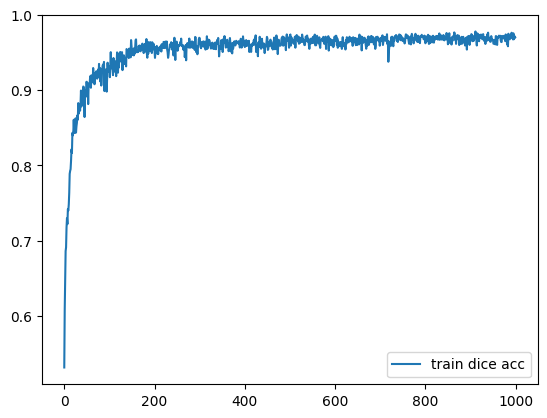

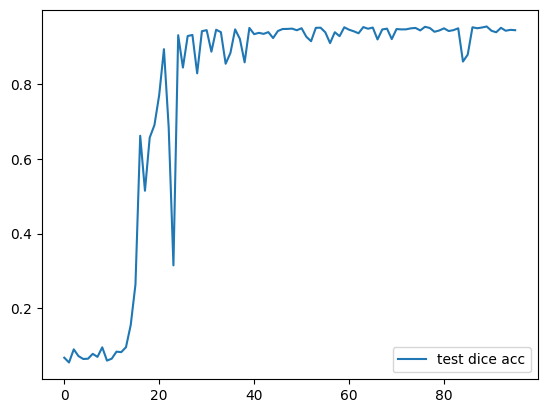

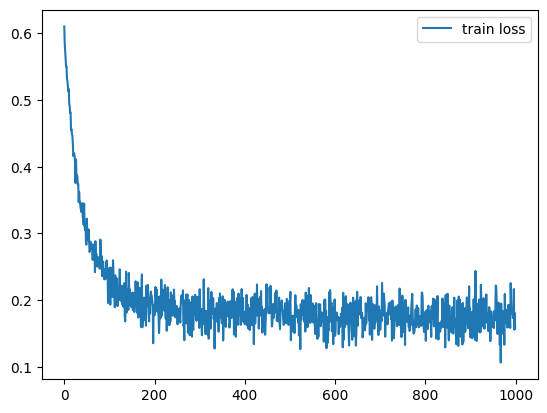

In [12]:
# Plot the loss and dice accuracy
mean_dice_accs = []
mean_test_dice_accs = []
mean_train_loss = []

for i in range(0, len(dice_accs), 16):
    mean_dice_accs.append(np.average(dice_accs[i:i+16]))
    mean_train_loss.append(np.average(losses[i:i+16]))

for i in range(0, len(test_dice_accs), 47):
    mean_test_dice_accs.append(np.average(test_dice_accs[i:i+9]))




plt.plot(mean_dice_accs, label="train dice acc")
plt.legend()
plt.show()

plt.plot(mean_test_dice_accs, label="test dice acc")
plt.legend()
plt.show()

plt.plot(mean_train_loss, label="train loss")
plt.legend()
plt.show()